# LUCA GIANDOMENICO MAT. 900162

# Download e import delle dipendenze

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getFamaFrenchFactors as gff
import datetime as dt
import seaborn as sns
import scipy
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import root_mean_squared_error
from IPython.display import display, Math
import warnings 
import pyfolio as pf

## Download dei dati storici con yFinance

In [2]:
start = pd.Timestamp('2014-05-31')
end = pd.Timestamp('2024-05-31')

tickers = ['NOC', 'BA', 'AMD', 'QCOM', 'BLK', 'GS']
data = yf.download(tickers = tickers, start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


## Presentazione dei dati con un grafico

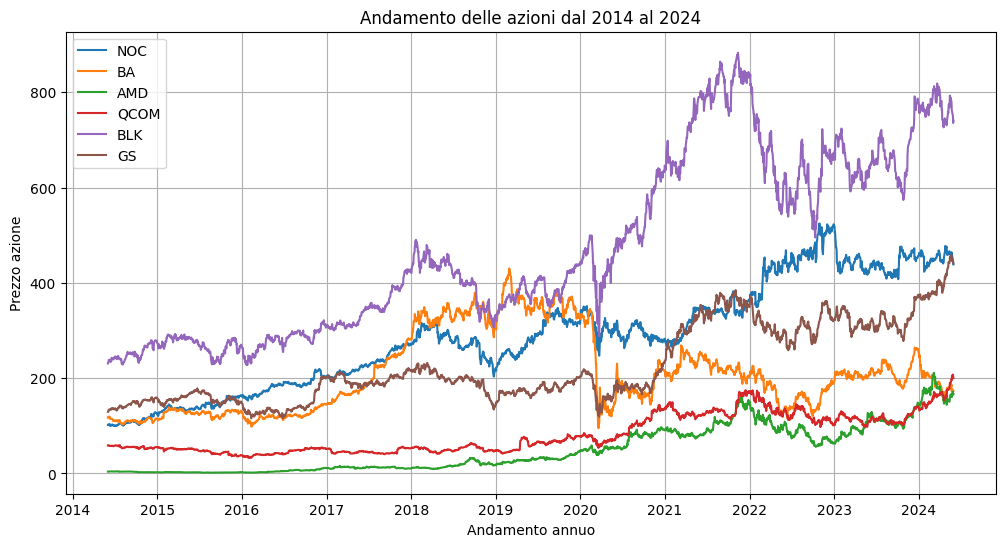

In [3]:
prezzi = data['Close']

plt.figure(figsize=(12, 6))

for ticker in tickers:
    plt.plot(prezzi.index, prezzi[ticker], label=ticker)

plt.title('Andamento delle azioni dal 2014 al 2024')
plt.xlabel('Andamento annuo')
plt.ylabel('Prezzo azione')
plt.grid(True)
plt.legend()    
plt.show()

## CAGR (Compounded Average Growth Rate)

NOC: 15.73%
BA: 3.93%
AMD: 45.28%
QCOM: 13.03%
BLK: 12.35%
GS: 13.05%


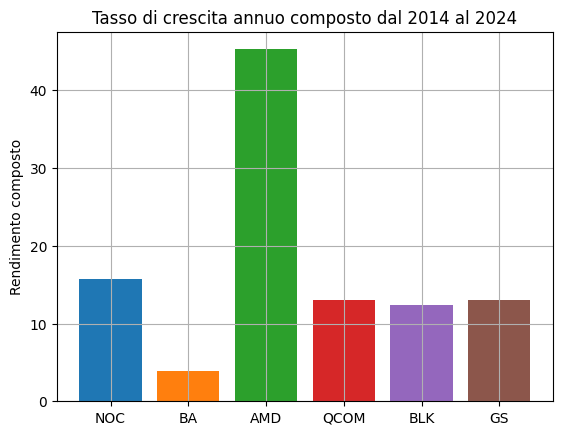

In [4]:
delta = end - start
t = delta.days
years = t/365

for ticker in tickers:
    cagr = (data.Close[ticker].iloc[-1] / data.Close[ticker].iloc[0]) ** (1 / years) - 1
    print(f"{ticker}: {cagr:.2%}")
    plt.bar(ticker, cagr*100)

plt.title('Tasso di crescita annuo composto dal 2014 al 2024')
plt.ylabel("Rendimento composto")
plt.grid(True)   
plt.show()

## Rendimento cumulato

NOC: 331.63%
BA: 47.07%
AMD: 4100.25%
QCOM: 240.60%
BLK: 220.87%
GS: 241.22%


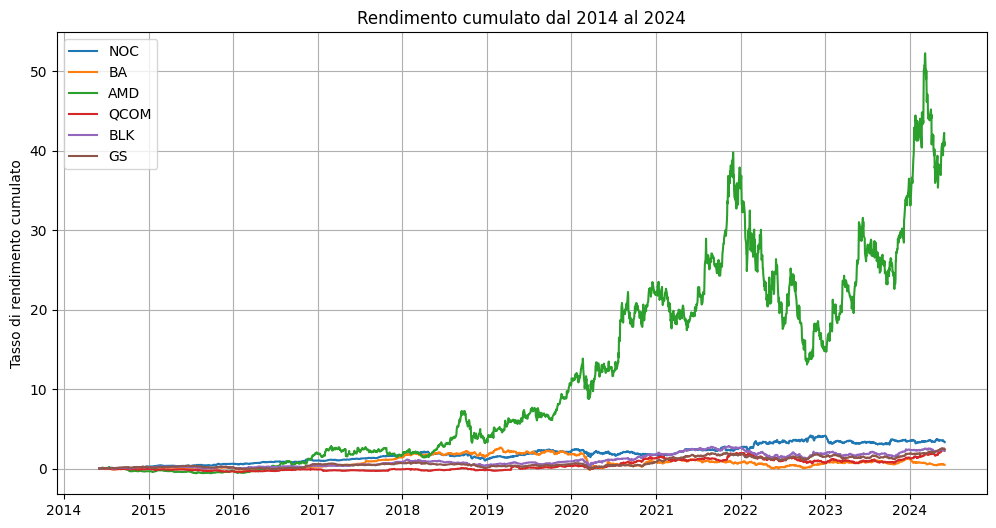

In [5]:
plt.figure(figsize=(12,6))

for ticker in tickers:
    prices = data.Close[ticker].dropna()
    cum_ret = prices / prices.iloc[0] - 1
    print(f"{ticker}: {cum_ret.iloc[-1]:.2%}")
    plt.plot(cum_ret, label=ticker)

plt.title('Rendimento cumulato dal 2014 al 2024')
plt.ylabel("Tasso di rendimento cumulato")
plt.grid(True)
plt.legend()
plt.show()

## Calcolo dei rendimenti lordi e logaritmici

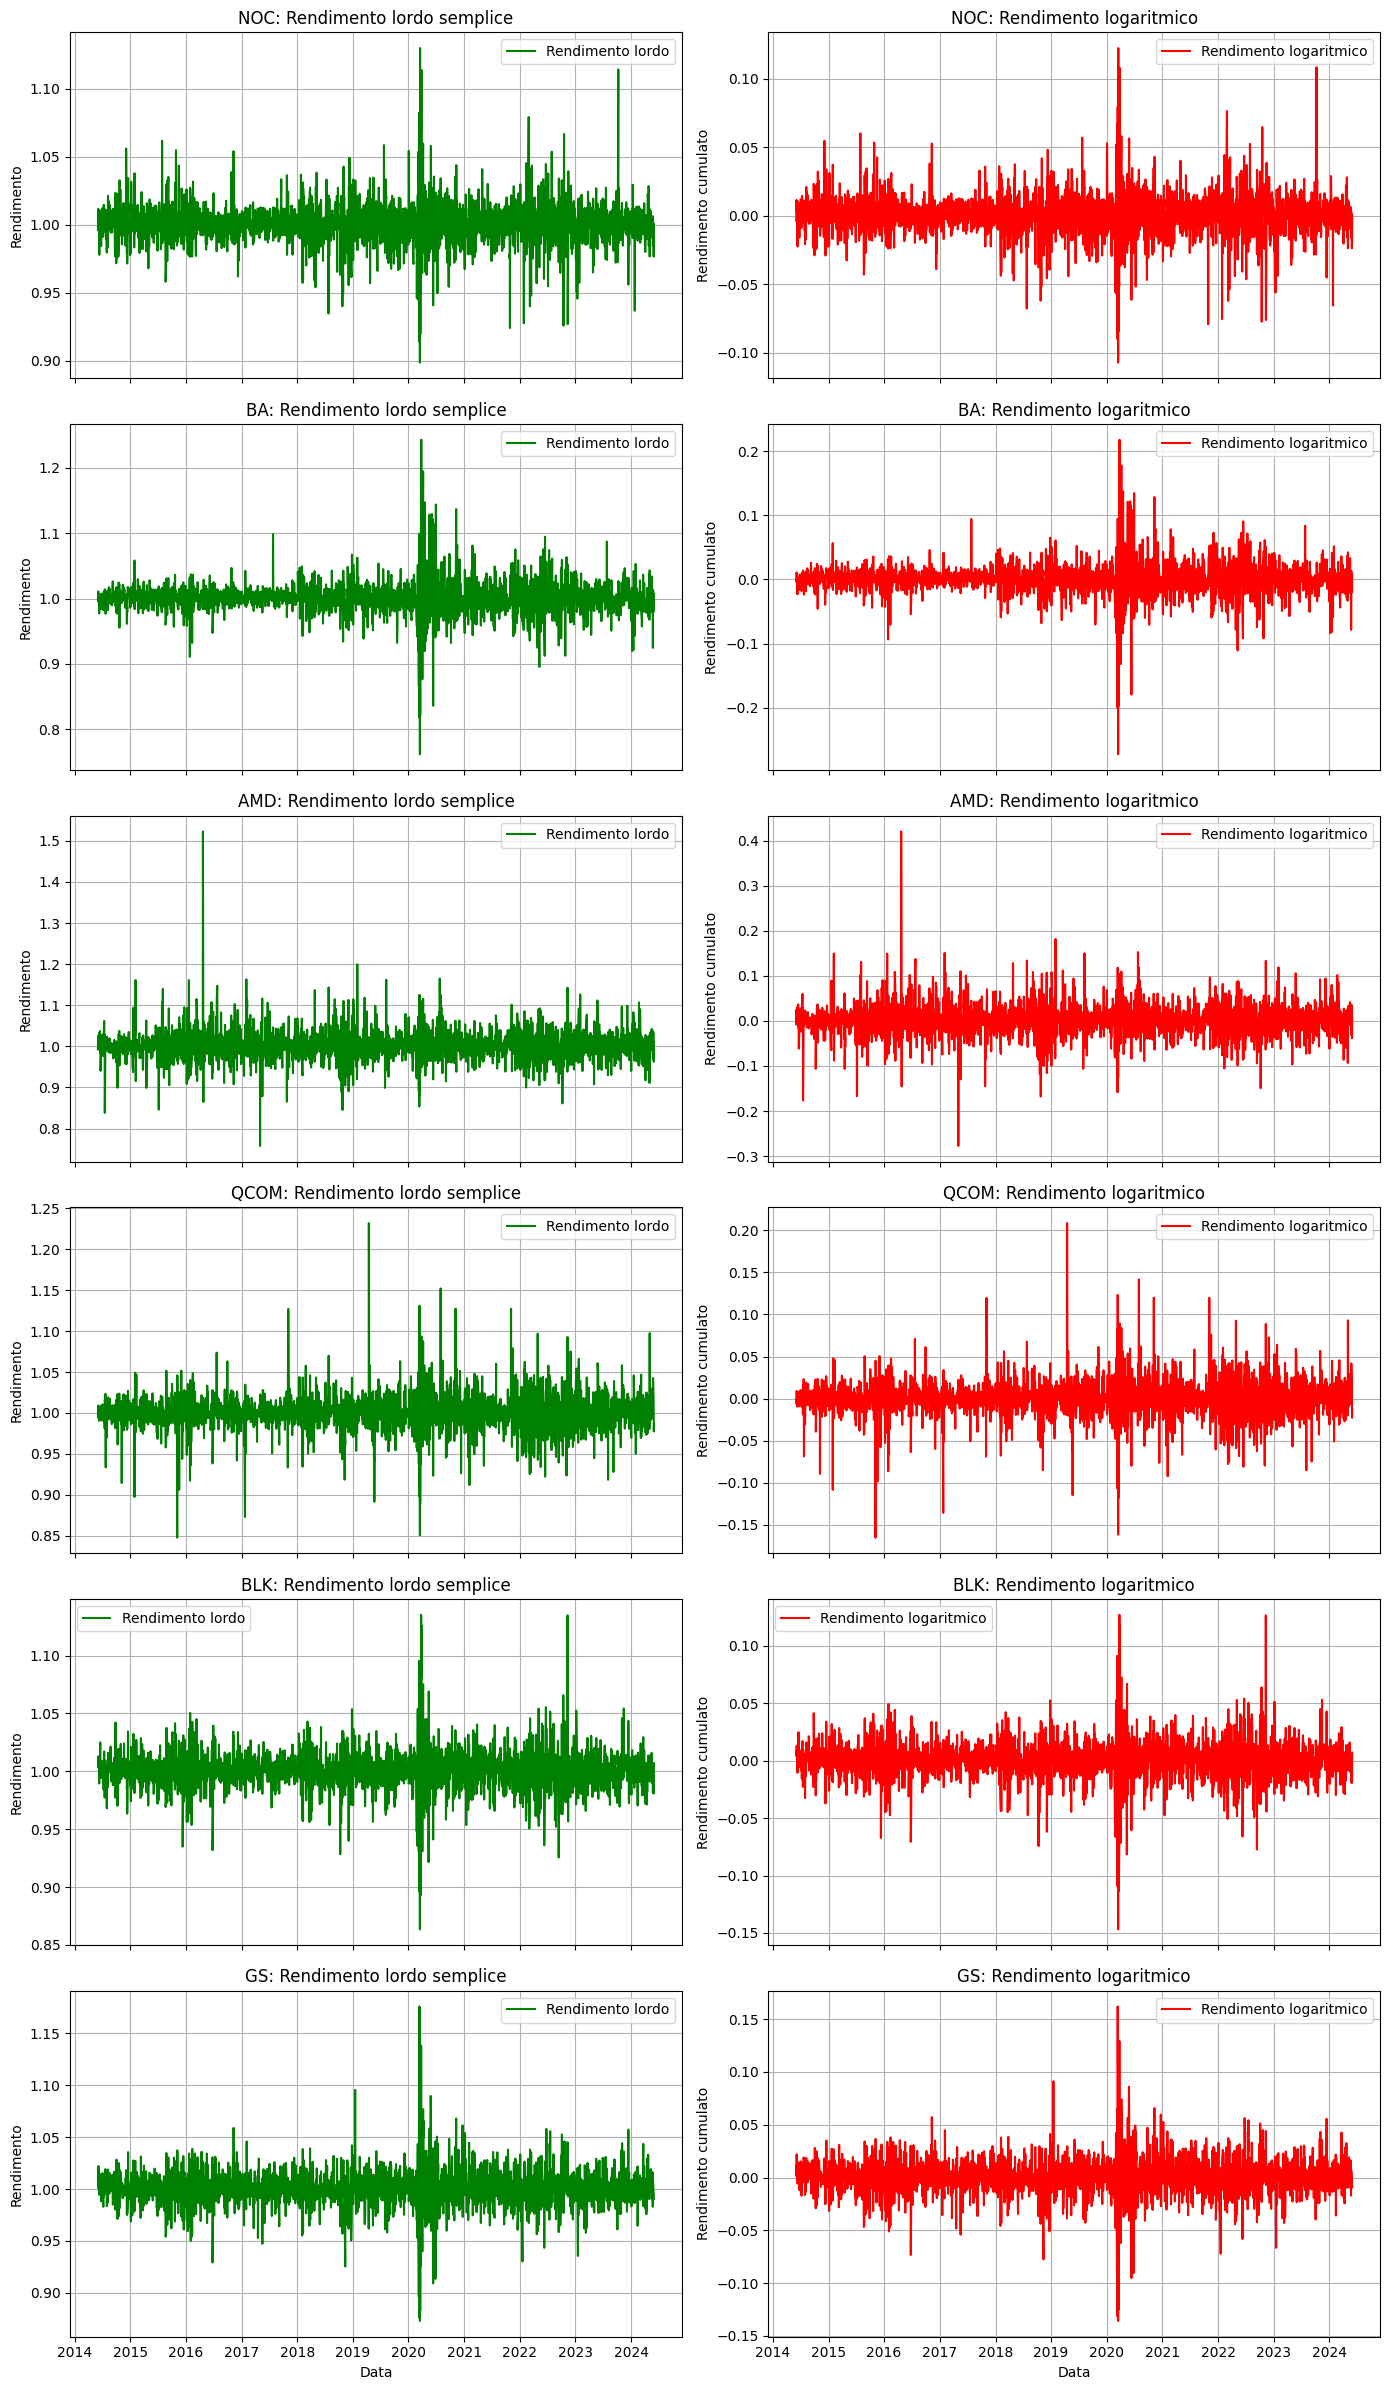

In [6]:
# Numero di titoli
n = len(tickers)

# Crea una griglia di subplot: n righe, 2 colonne
fig, axs = plt.subplots(n, 2, figsize=(14, 4 * n), sharex=True)

for i, ticker in enumerate(tickers):
    gross_ret = (data.Close[ticker]/data.Close[ticker].shift(1))
    log_ret = np.log(data.Close[ticker]/data.Close[ticker].shift(1))

    # Colonna 1: Rendimento lordo semplice
    axs[i, 0].plot(gross_ret, color="green", label="Rendimento lordo")
    axs[i, 0].set_title(f'{ticker}: Rendimento lordo semplice')
    axs[i, 0].set_ylabel("Rendimento")
    axs[i, 0].grid(True)
    axs[i, 0].legend()

    # Colonna 2: Rendimento logaritmico cumulativo
    axs[i, 1].plot(log_ret, color="red", label="Rendimento logaritmico")
    axs[i, 1].set_title(f'{ticker}: Rendimento logaritmico')
    axs[i, 1].set_ylabel("Rendimento cumulato")
    axs[i, 1].grid(True)
    axs[i, 1].legend()

if i == n - 1:
    axs[i, 0].set_xlabel("Data")
    axs[i, 1].set_xlabel("Data")

plt.tight_layout()
plt.show()

Aggiunta delle colonne per il rendimento lordo e per il rendimento logaritmico al dataframe di partenza

In [7]:
# DataFrame vuoti
gross_returns = pd.DataFrame(index=data.index)
log_returns = pd.DataFrame(index=data.index)

# Calcola i rendimenti per ogni ticker
for ticker in tickers:
    gross_returns[ticker] = data.Close[ticker] / data.Close[ticker].shift(1)
    log_returns[ticker] = np.log(data.Close[ticker] / data.Close[ticker].shift(1))

# Combino in un unico DataFrame multindex
returns = pd.concat(
    {'Gross_Ret': gross_returns, 'Log_Ret': log_returns},
    axis=1
)

# Siccome il primo valore di ogni serie diventa automaticamente null perché non esiste un valore precedente per fare il calcolo utilizzo dropna() per rimuovere la riga nulla
returns = returns.dropna()

# Grafici Diagnostici

# Histogram

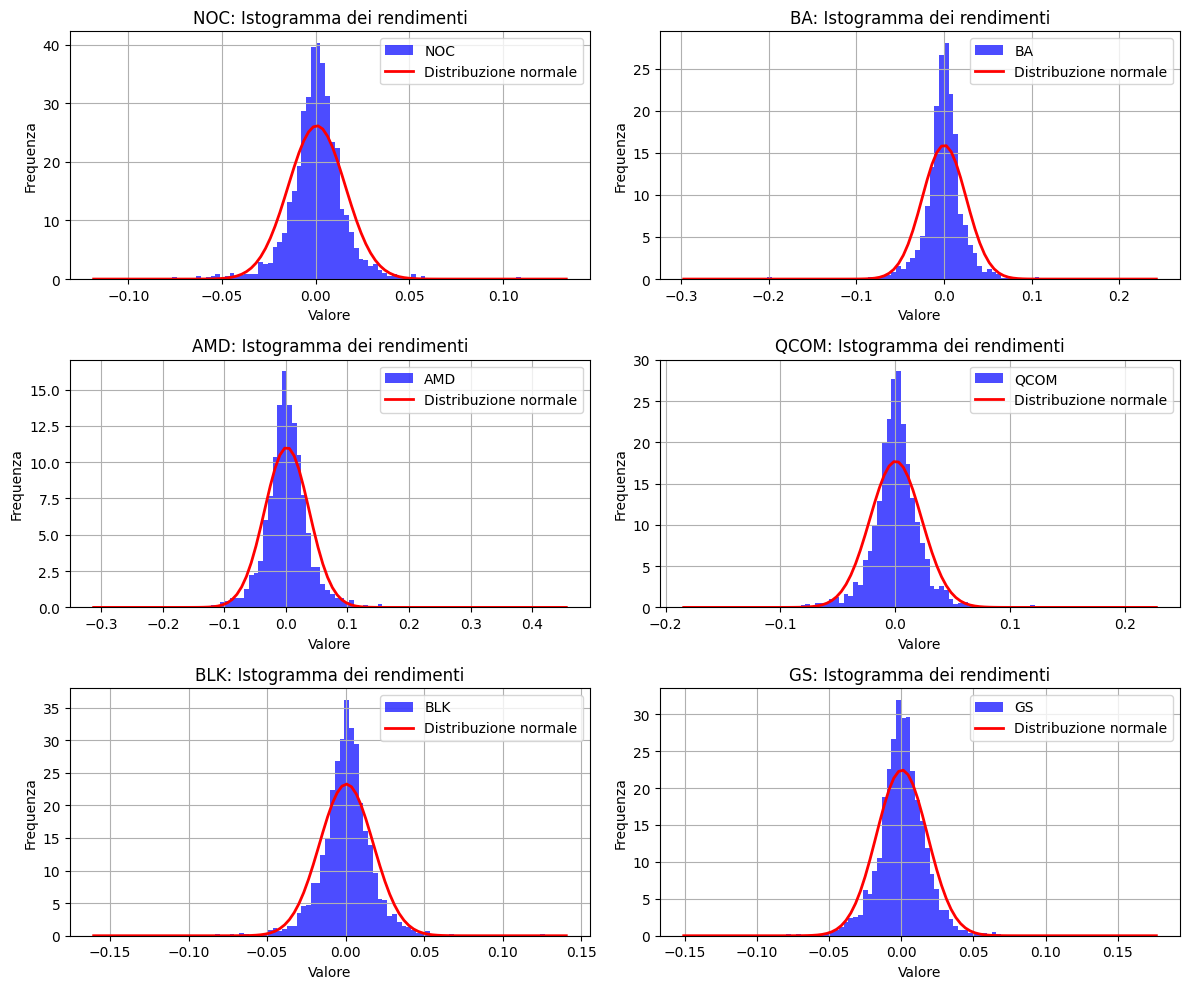

In [8]:
from scipy.stats import norm

# Stampa dei subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

for i, ticker in enumerate(tickers):
    ax = axs[i]
    dt = returns.Log_Ret[ticker]
    
    ax.hist(dt, bins=90, density=True, alpha=0.7, color='blue', label=f'{ticker}')
    
    mu, std = np.mean(dt), np.std(dt)
    xmin, xmax = ax.get_xlim()
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2, label='Distribuzione normale')
    
    ax.set_xlabel('Valore')
    ax.set_ylabel('Frequenza')
    ax.set_title(f'{ticker}: Istogramma dei rendimenti')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

# Box Plot

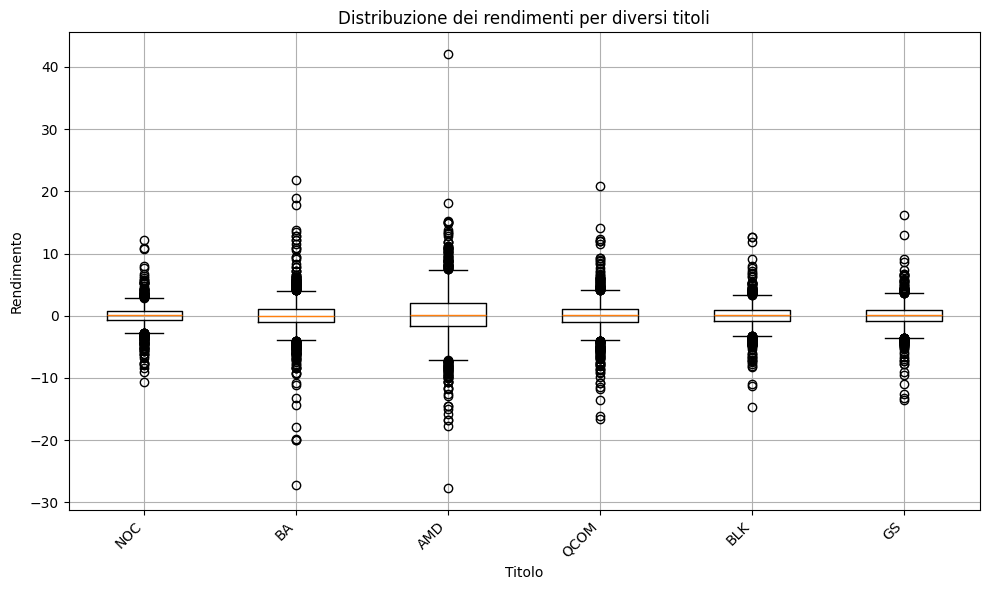

In [9]:
plt.figure(figsize=(10, 6))
plt.boxplot(returns.Log_Ret.dropna()*100, tick_labels= tickers)
plt.title('Distribuzione dei rendimenti per diversi titoli')
plt.ylabel ('Rendimento')
plt.xlabel ('Titolo')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Q-Q Plots

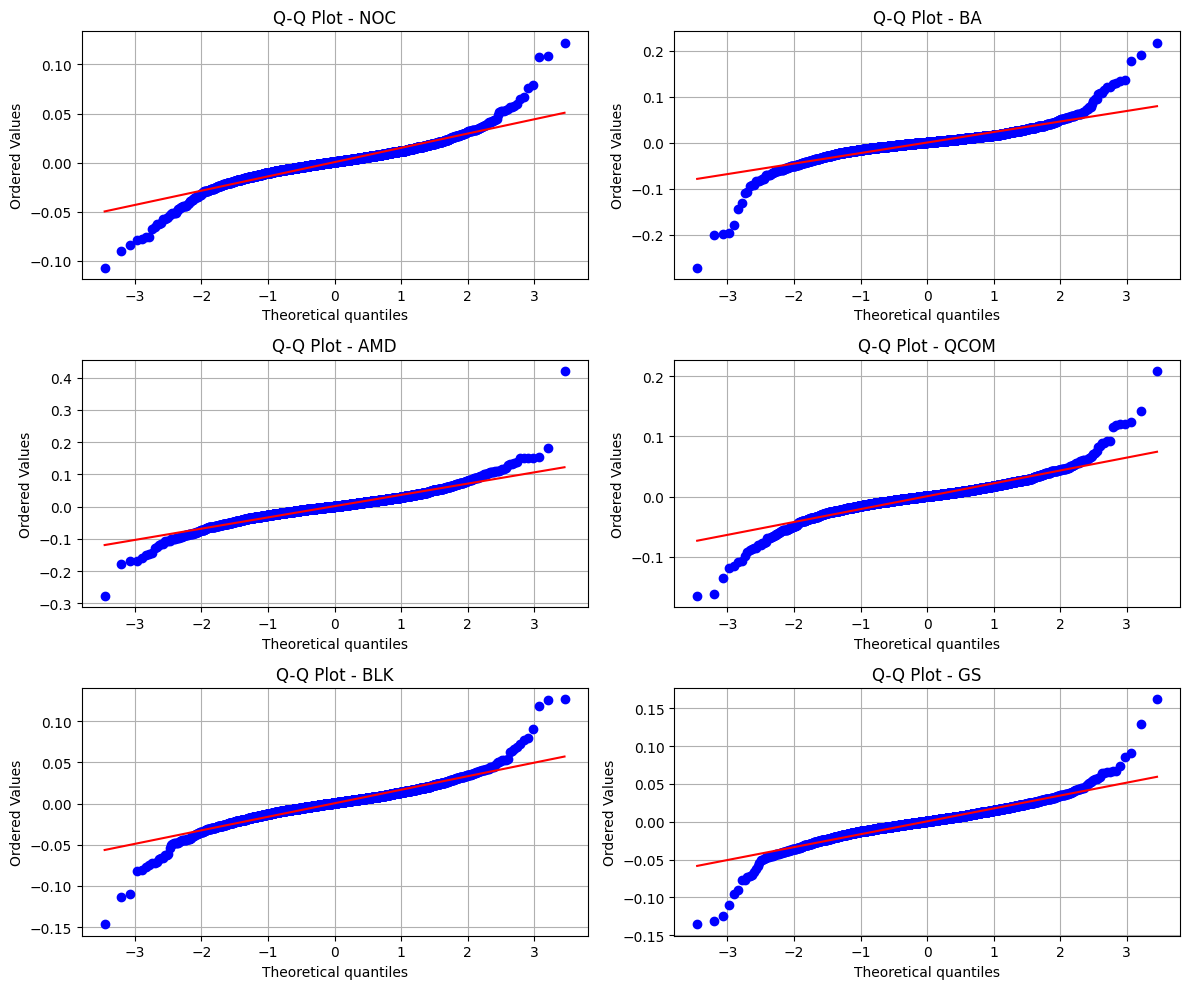

In [10]:
from scipy import stats
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

for i, ticker in enumerate(tickers):
    ax = axs[i]
    dt = returns[('Log_Ret', ticker)].dropna()
    
    stats.probplot(dt, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot - {ticker}')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Kernel density Plot


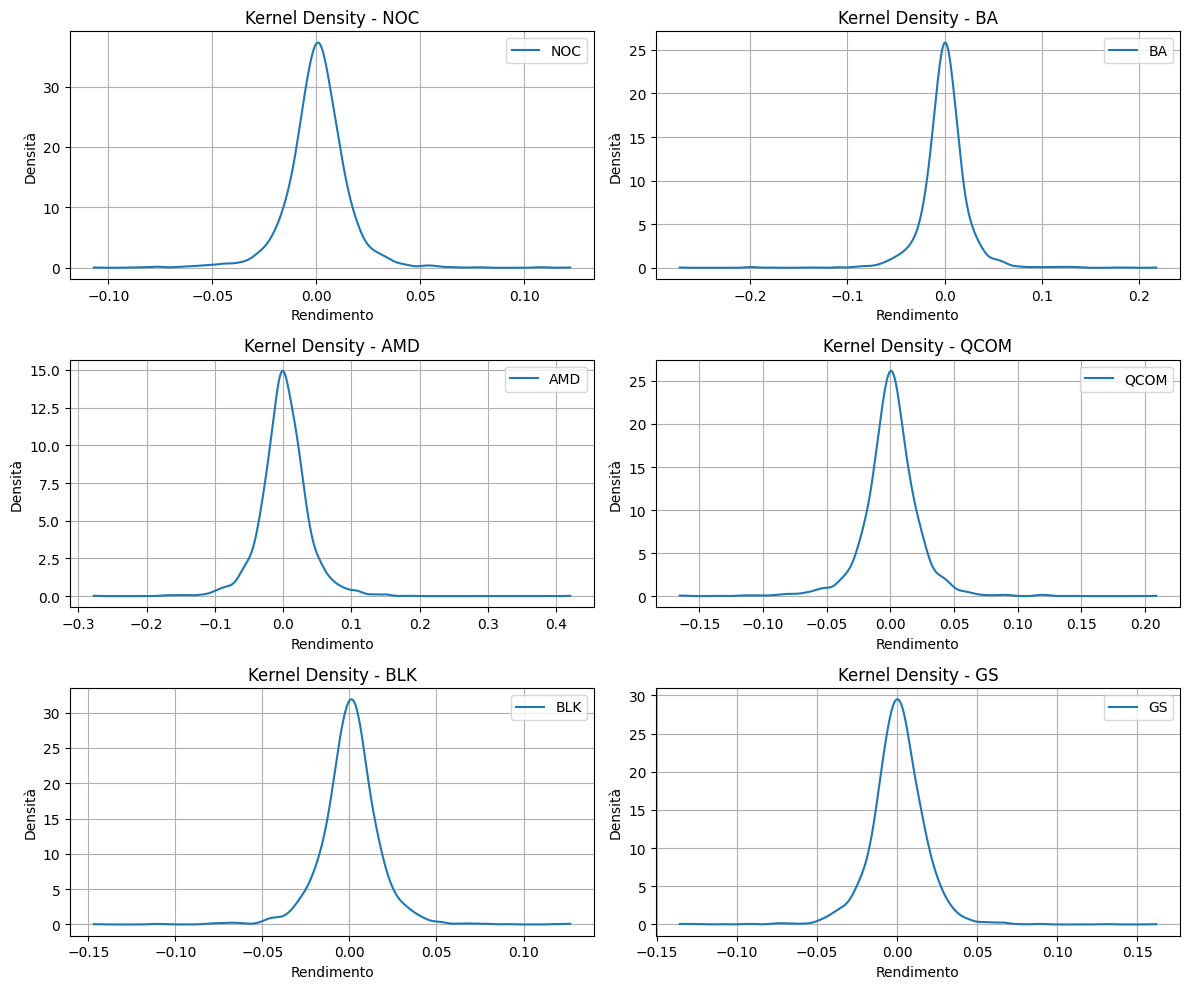

In [11]:
from scipy import stats
stats.gaussian_kde

# Creazione di una griglia di subplot 3x2 per visualizzare i grafici KDE
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten() 

# Ciclo attraverso ogni ticker per creare un grafico KDE separato
for i, ticker in enumerate(tickers):
    ax = axs[i]
    # Converte in numerico, rimuove i valori NaN e trasforma in array numpy
    dt = pd.to_numeric(returns.Log_Ret[ticker], errors='coerce').dropna().to_numpy()
    
    # Creazione del Kernel Density Estimator (KDE) usando un kernel gaussiano
    kde = stats.gaussian_kde(dt)
    x = np.linspace(min(dt), max(dt), 1000)
    y = kde(x)
    
    # Creazione del grafico della densità stimata
    ax.plot(x, y, label=f'{ticker}')
    ax.set_title(f'Kernel Density - {ticker}')
    ax.set_xlabel('Rendimento')
    ax.set_ylabel('Densità')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# Statistiche univariate annualizzate

In [12]:
from scipy.stats import skew, kurtosis

# Definizione dei giorni di trading durante l'anno
trading_days = 252
stats  = []

# Ciclo attraverso ogni ticker per calcolare le statistiche annualizzate
for ticker in tickers:
    mean = (returns.Log_Ret[ticker].mean() * trading_days)
    variance = (returns.Log_Ret[ticker].var() * trading_days)
    std_dev = returns.Log_Ret[ticker].std() * (trading_days ** 0.5)
    skewness = returns.Log_Ret[ticker].skew()
    kurt = returns.Log_Ret[ticker].kurtosis()

    # Aggiunta delle statistiche calcolate alla lista
    stats.append({
        "Ticker": ticker,
        "Media": mean,
        "Varianza": variance,
        "Dev. Std": std_dev,
        "Skewness": skewness,
        "Curtosi": kurt
    })

df_stats = pd.DataFrame(stats)
print(df_stats.round(6))

  Ticker     Media  Varianza  Dev. Std  Skewness    Curtosi
0    NOC  0.146472  0.058574  0.242020 -0.060967   8.288640
1     BA  0.038636  0.158507  0.398129 -0.521244  18.697379
2    AMD  0.374367  0.330602  0.574980  0.475704  10.665615
3   QCOM  0.122748  0.127936  0.357681 -0.042347   9.653425
4    BLK  0.116771  0.074091  0.272197 -0.160579   8.742705
5     GS  0.122931  0.079660  0.282241 -0.202517   9.576098


# Calcolo dei rendimenti mensili

In [13]:
for ticker in tickers:
    monthly_ret = returns.Log_Ret[ticker].groupby(pd.Grouper(freq='ME')).sum()
    print(f'{ticker}', monthly_ret)

NOC Date
2014-06-30   -0.019289
2014-07-31    0.029974
2014-08-31    0.037041
2014-09-30    0.035064
2014-10-31    0.045982
                ...   
2024-01-31   -0.046746
2024-02-29    0.035520
2024-03-31    0.037549
2024-04-30    0.013220
2024-05-31   -0.078308
Freq: ME, Name: NOC, Length: 120, dtype: float64
BA Date
2014-06-30   -0.065923
2014-07-31   -0.054513
2014-08-31    0.057165
2014-09-30    0.004564
2014-10-31   -0.019581
                ...   
2024-01-31   -0.211169
2024-02-29   -0.035301
2024-03-31   -0.054108
2024-04-30   -0.139627
2024-05-31    0.028834
Freq: ME, Name: BA, Length: 120, dtype: float64
AMD Date
2014-06-30    0.053935
2014-07-31   -0.069163
2014-08-31    0.064379
2014-09-30   -0.201204
2014-10-31   -0.197093
                ...   
2024-01-31    0.128899
2024-02-29    0.138135
2024-03-31   -0.064577
2024-04-30   -0.130678
2024-05-31    0.051498
Freq: ME, Name: AMD, Length: 120, dtype: float64
QCOM Date
2014-06-30   -0.016032
2014-07-31   -0.071702
2014-08-31   

**Creazione di un nuovo dataframe per i ritorni mensili**

In [14]:
# Nuovo dataframe con i ritorni mensili
monthly_log_returns = pd.DataFrame()

for ticker in tickers:
    monthly_log_returns[ticker] = returns.Log_Ret[ticker].groupby(pd.Grouper(freq='ME')).sum()

# Matrice di correlazione e delle covarianze

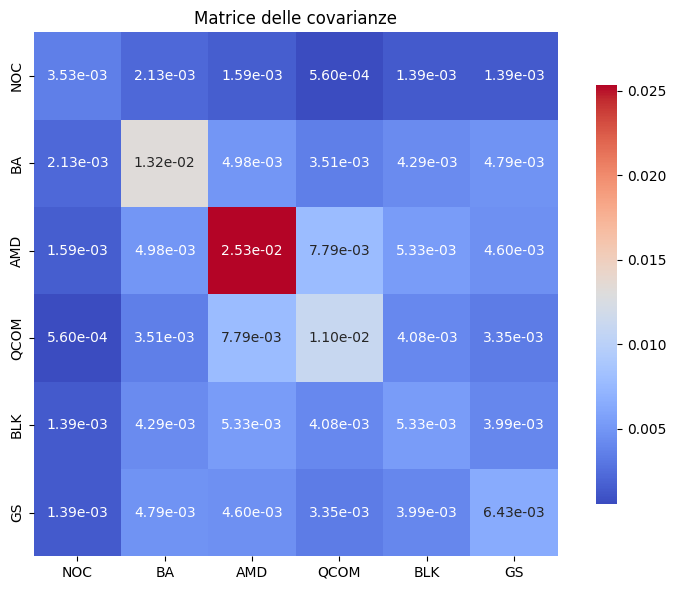

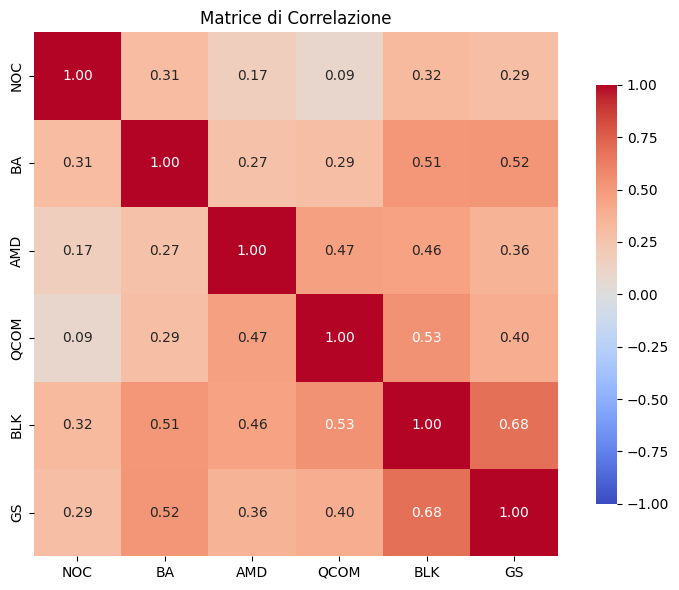

In [15]:
# Matrice di covarianza
cov_matrix = monthly_log_returns.cov()

# Visualizzazione heatmap della matrice di covarianza
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt=".2e", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Matrice delle covarianze")
plt.tight_layout()
plt.show()

# Matrice di correlazione
corr_matrix = monthly_log_returns.corr()

# Visualizzazione heatmap della matrice di correlazione
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Matrice di Correlazione")
plt.tight_layout()
plt.show()

**Titoli più e meno correlati**

In [ ]:
corr_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_no_diag.values, np.nan)

# Converte la matrice in formato lungo
correlations_long = corr_no_diag.unstack()

# Rimuovi i valori NaN
correlations_clean = correlations_long.dropna()

# Rimuovi i duplicati manualmente
unique_pairs = []
seen_pairs = set()

for index, value in correlations_clean.items():
    # Ordina la coppia per evitare duplicati (A,B) e (B,A)
    pair = tuple(sorted([index[0], index[1]]))
    
    if pair not in seen_pairs:
        unique_pairs.append((index[0], index[1], value))
        seen_pairs.add(pair)

# Converti in DataFrame per facilità di ordinamento
df_correlations = pd.DataFrame(unique_pairs, columns=['Stock 1', 'Stock 2', 'Correlazione'])

# Ordina per correlazione
df_sorted_least_corr = df_correlations.sort_values('Correlazione', ascending=True)

df_sorted_highest_corr = df_correlations.sort_values('Correlazione', ascending=False)

print("Titoli più correlati:")
print(df_sorted_highest_corr.head(5))

print("\nTitoli meno correlati:")
print(df_sorted_least_corr.head(5))

Titoli più correlati:
   Stock 1 Stock 2  Correlazione
14     BLK      GS      0.681511
12    QCOM     BLK      0.532460
8       BA      GS      0.519511
7       BA     BLK      0.511207
9      AMD    QCOM      0.465764

Titoli meno correlati:
  Stock 1 Stock 2  Correlazione
4     NOC      GS      0.291145
6      BA    QCOM      0.290608
5      BA     AMD      0.272520
1     NOC     AMD      0.167678
2     NOC    QCOM      0.089807


# Grafico dell'andamento nel tempo delle correlazioni tra titoli dello stesso settore

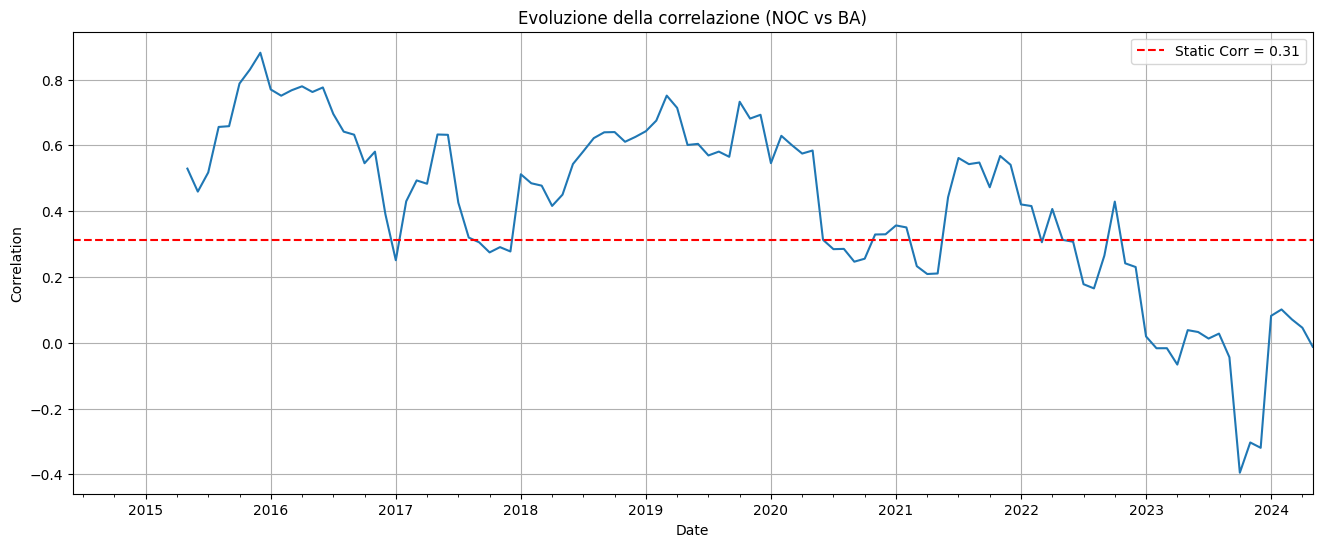

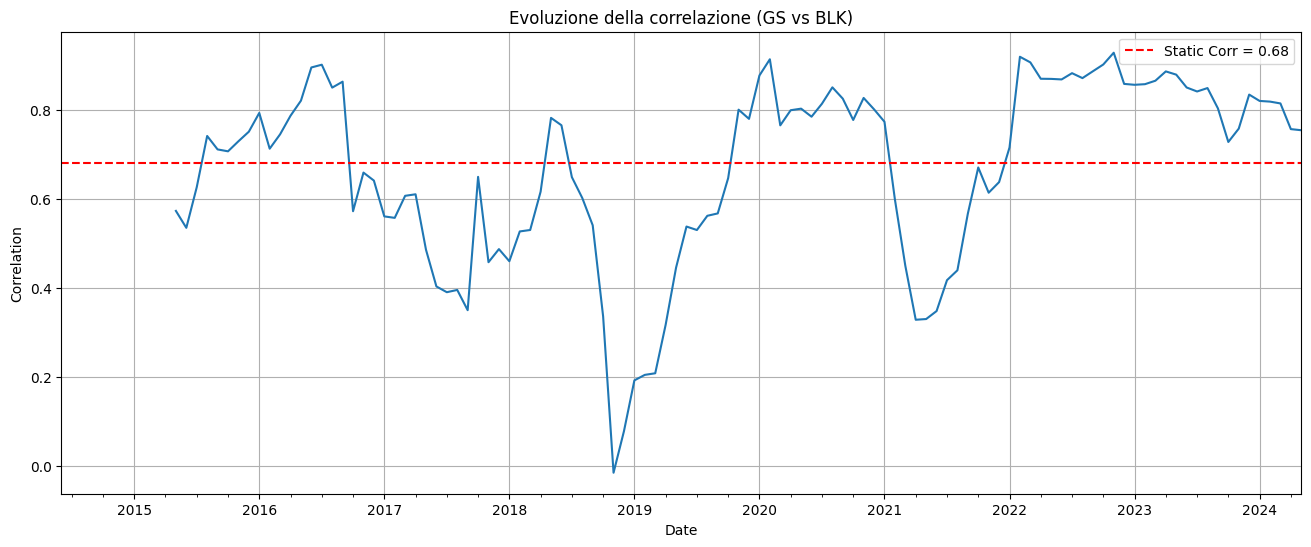

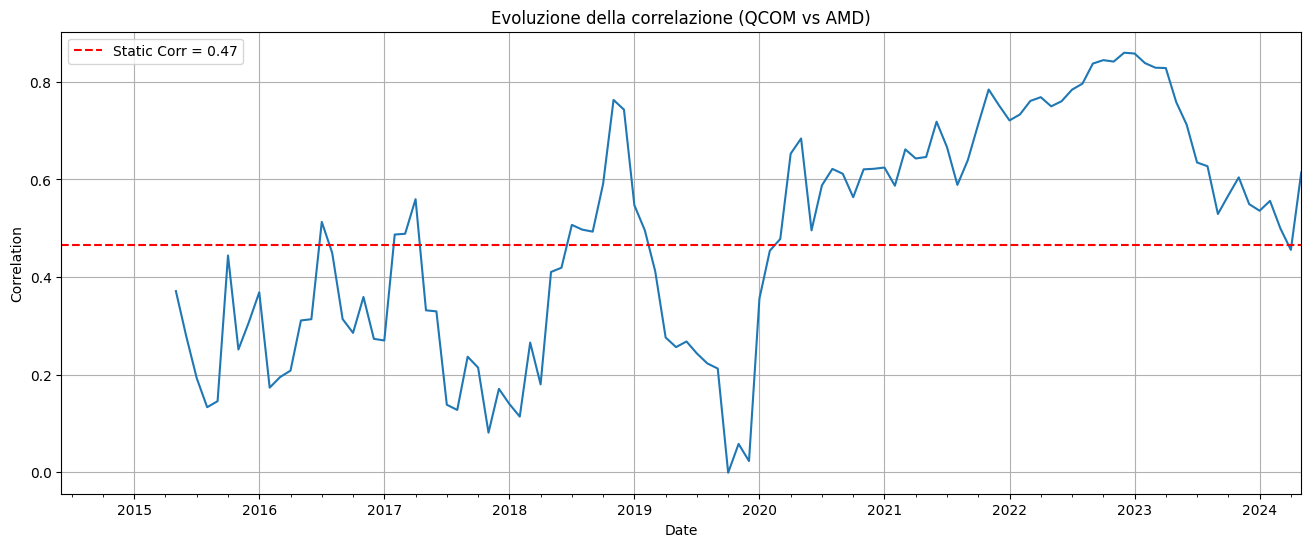

In [17]:
# Coppie di titoli dello stesso settore
pairs = [('NOC', 'BA'), ('GS', 'BLK'), ('QCOM', 'AMD')]

# Finestra mobile di 12 mesi per il calcolo della correlazione rolling
window = 12

# Ciclo attraverso ogni coppia di titoli per analizzare l'evoluzione della correlazione
for t1, t2 in pairs:
    rolling_corr = monthly_log_returns[t1].rolling(window=window).corr(monthly_log_returns[t2])
    static_corr = monthly_log_returns[[t1, t2]].corr().iloc[0, 1]
    
    # Creazione del grafico della correlazione rolling
    ax = rolling_corr.plot(figsize=(16, 6), title=f'Evoluzione della correlazione ({t1} vs {t2})')
    ax.axhline(static_corr, color='red', linestyle='--', label=f'Static Corr = {static_corr:.2f}')
    ax.set_ylabel('Correlation')
    ax.legend()
    plt.grid()
    plt.show()

# Scatter plot per rendimenti di due titoli nello stesso settore

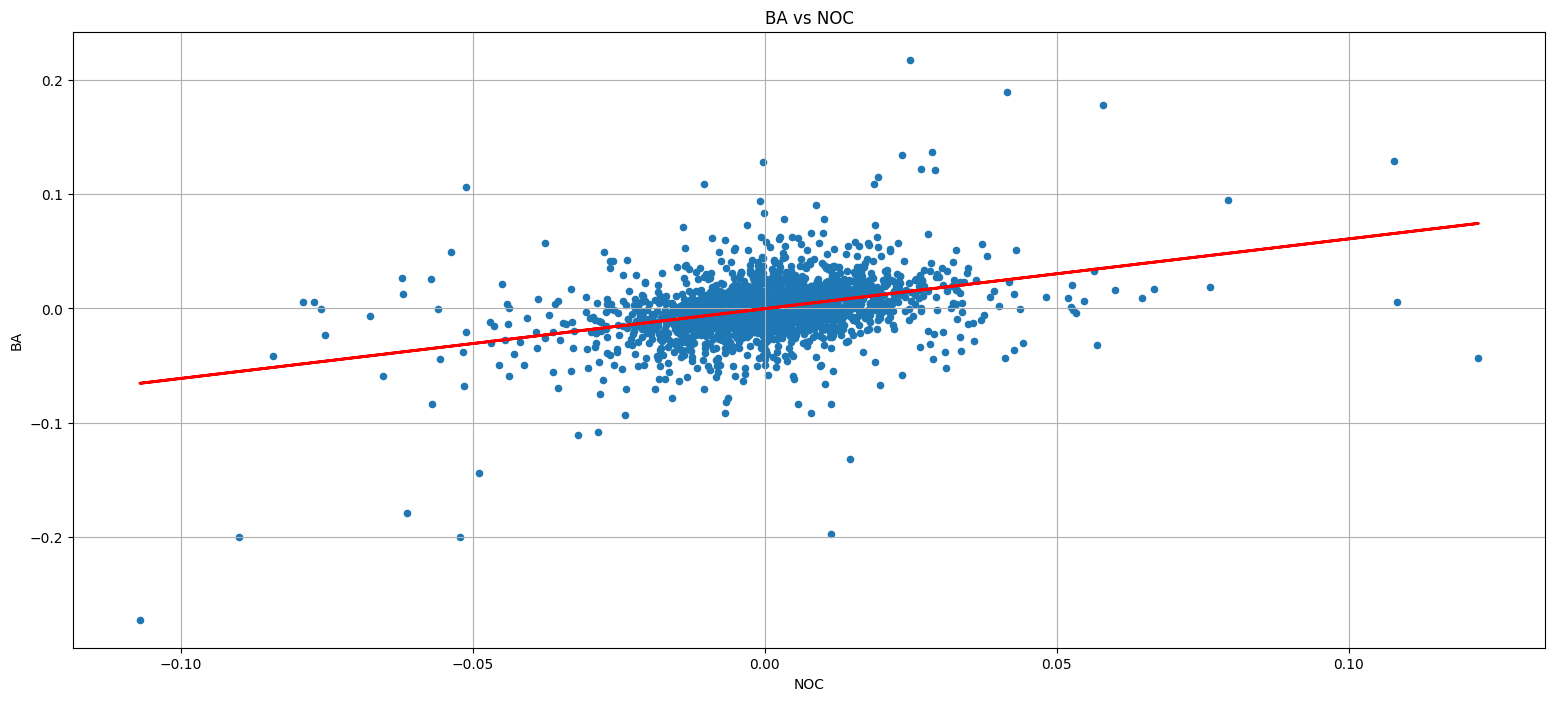

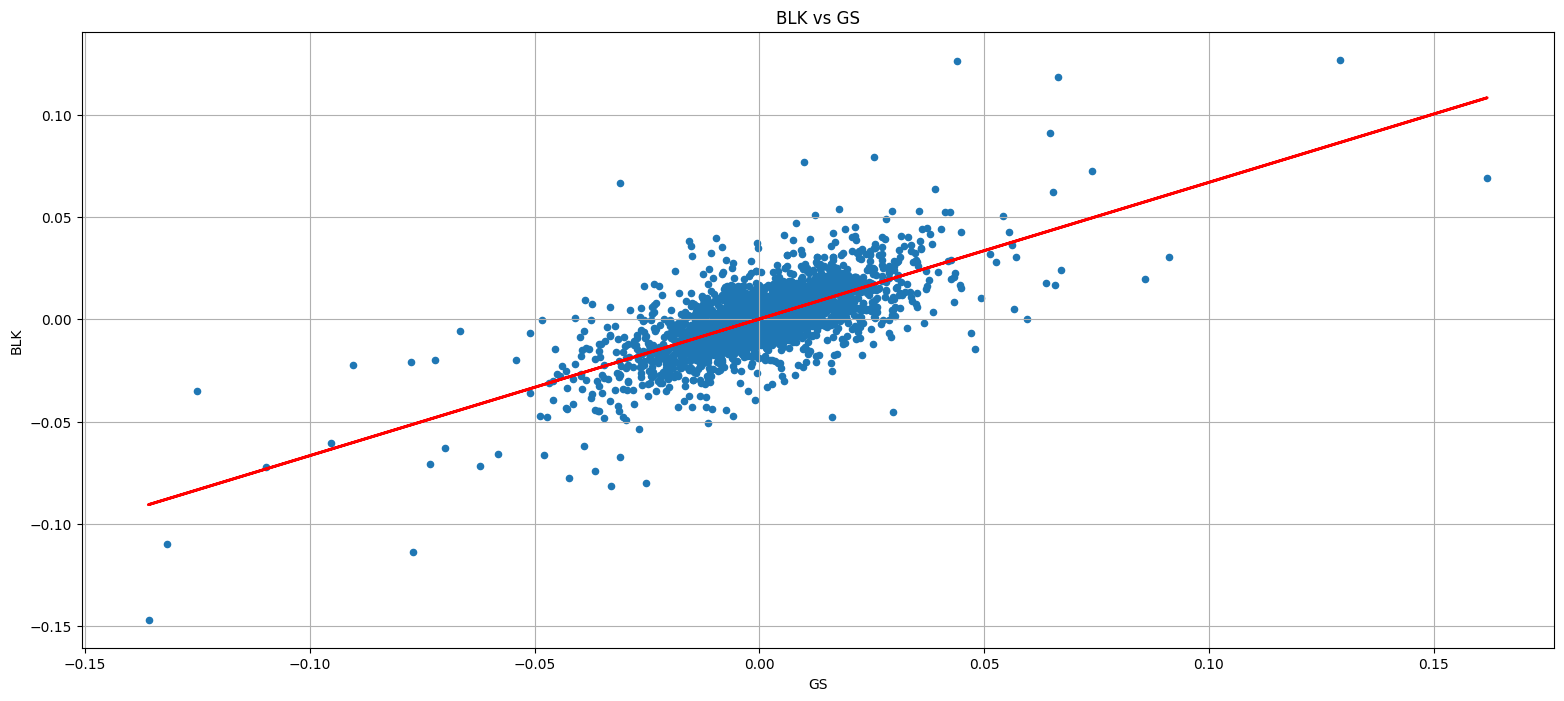

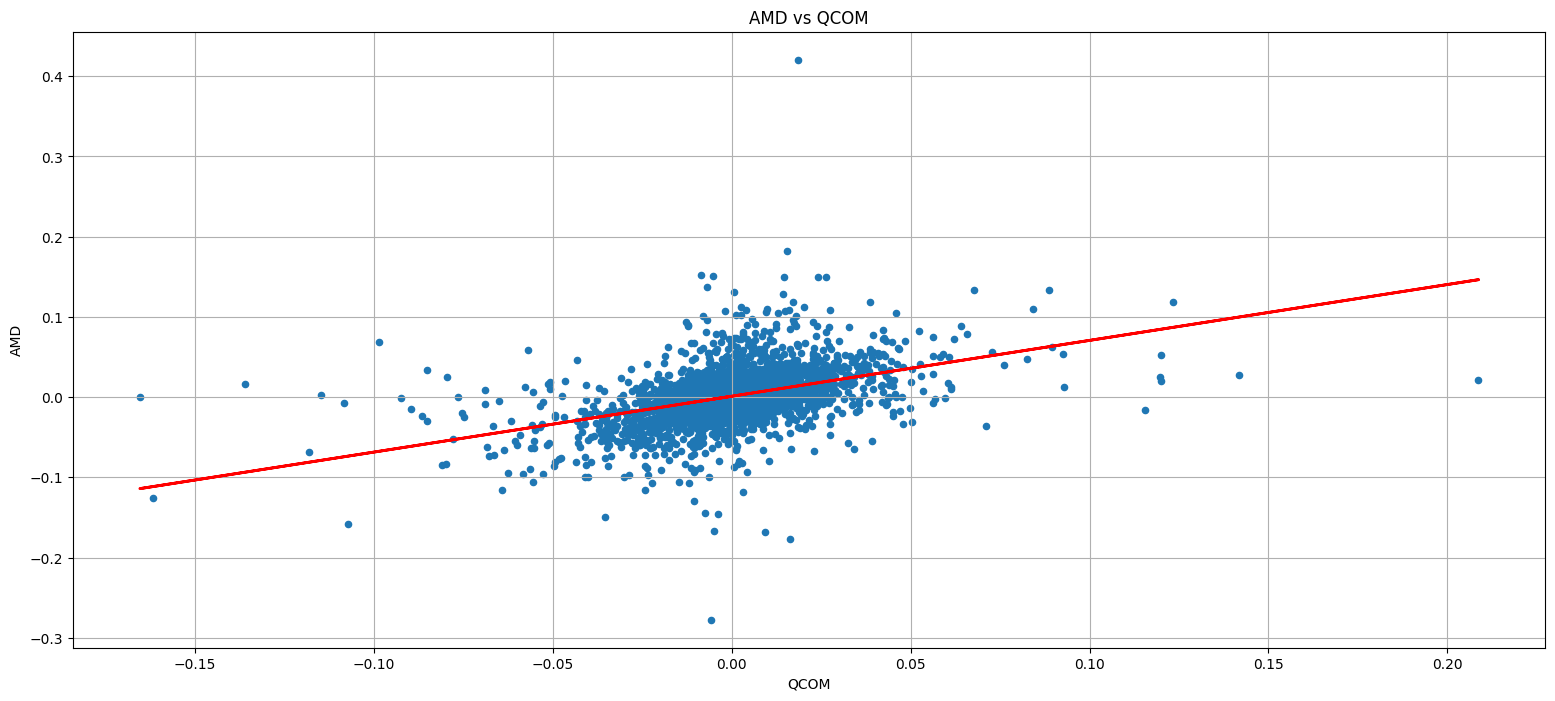

In [18]:
pairs = [('NOC', 'BA'), ('GS', 'BLK'), ('QCOM', 'AMD')] 

# Creazione delgli scatter plot per ogni coppia di titoli
for t1, t2 in pairs: 
    reg = np.polyfit(returns.Log_Ret[t1], returns.Log_Ret[t2], deg=1) 
    ax = returns.Log_Ret.plot(kind='scatter', x=t1, y=t2, title=f'{t2} vs {t1}', figsize=(19,8)) 
    ax.plot(returns.Log_Ret[t1], np.polyval(reg, returns.Log_Ret[t1]), 'r', lw=2) 
    plt.grid()

# Analisi di pevisione - (ARIMA)

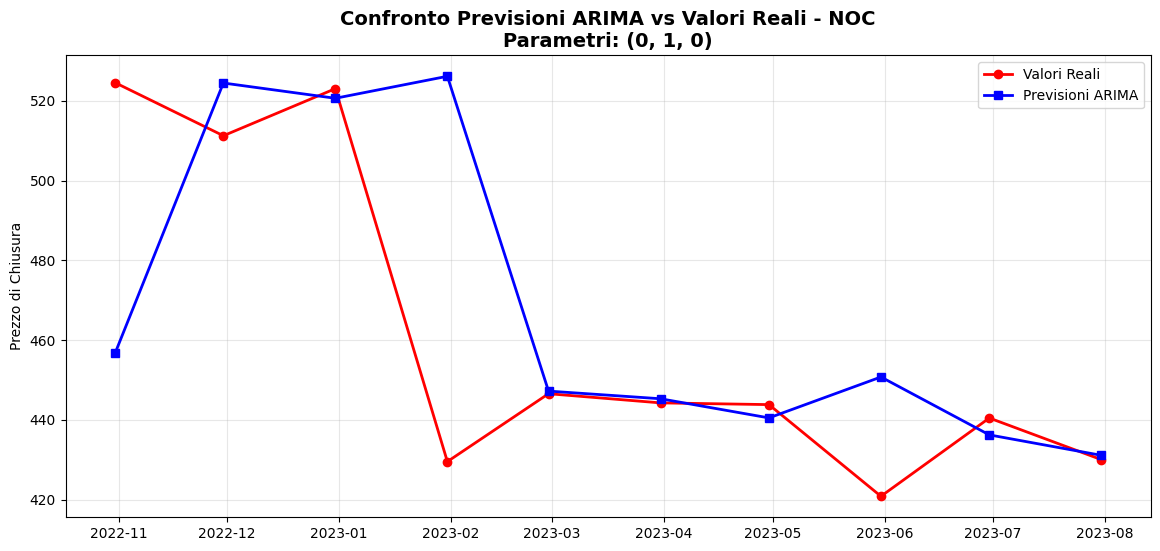

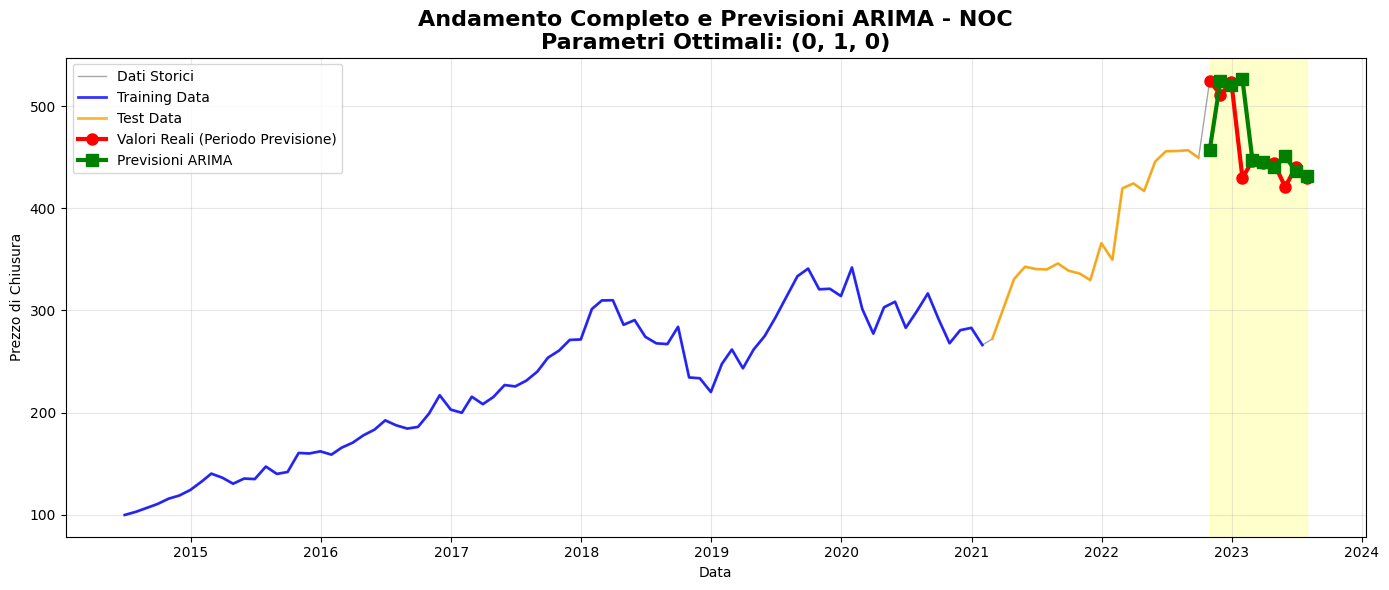

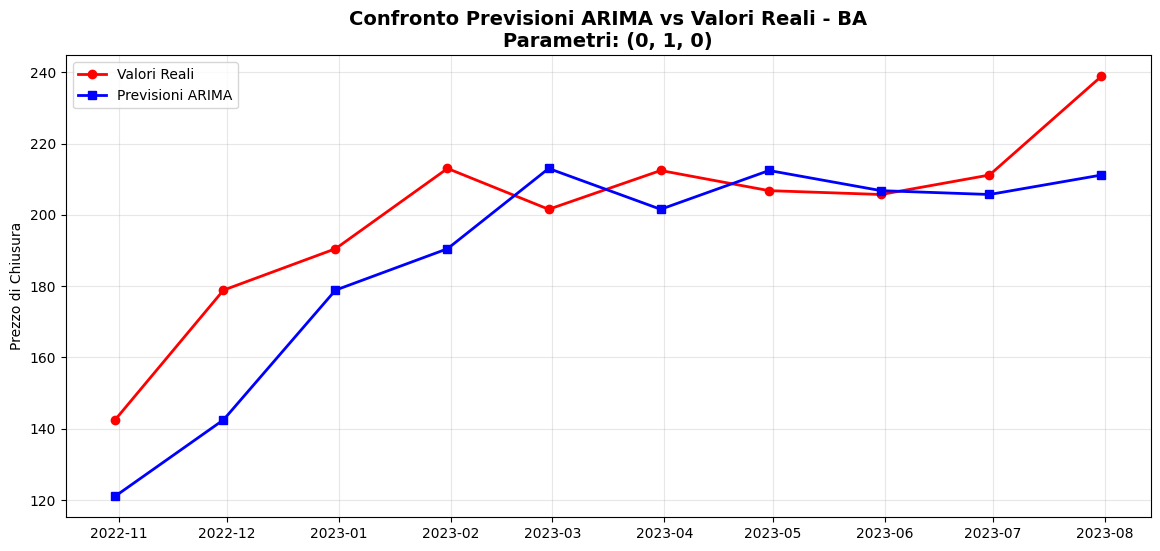

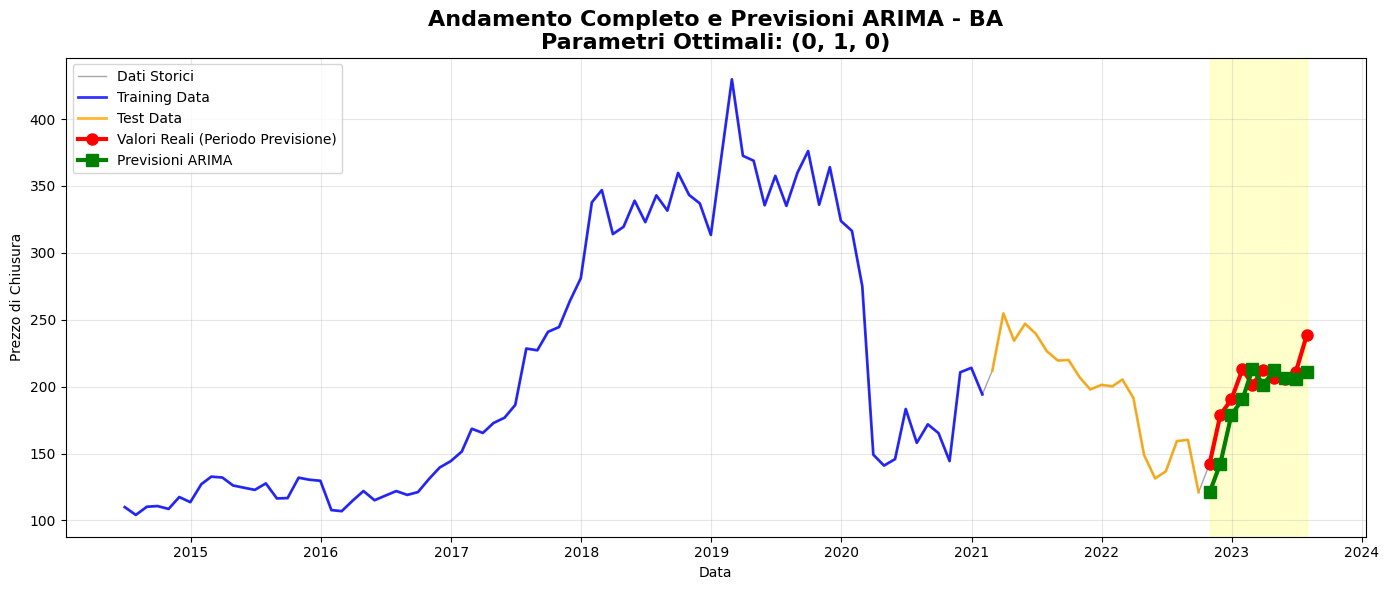

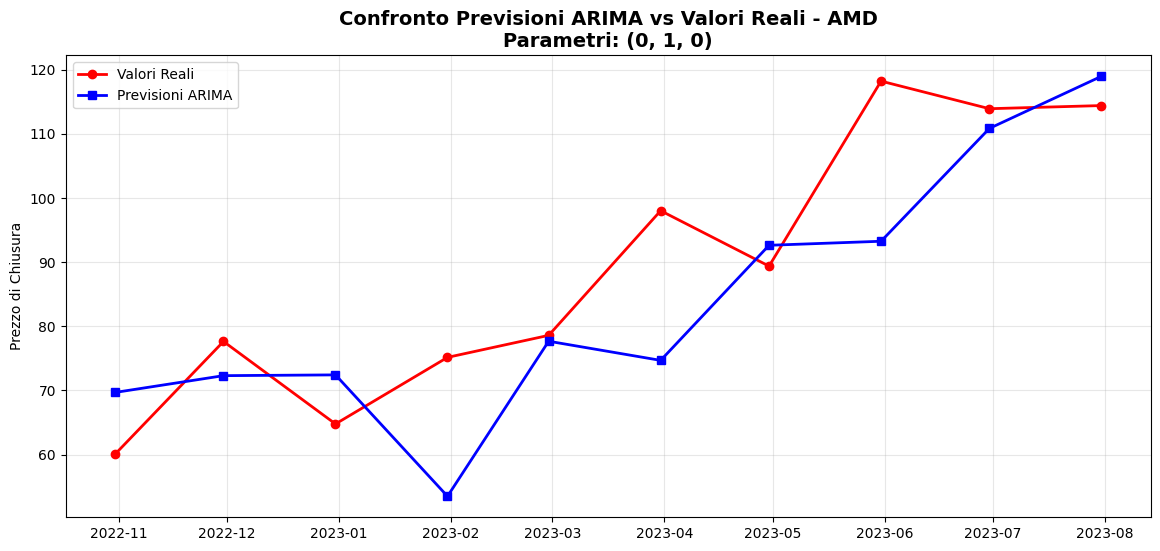

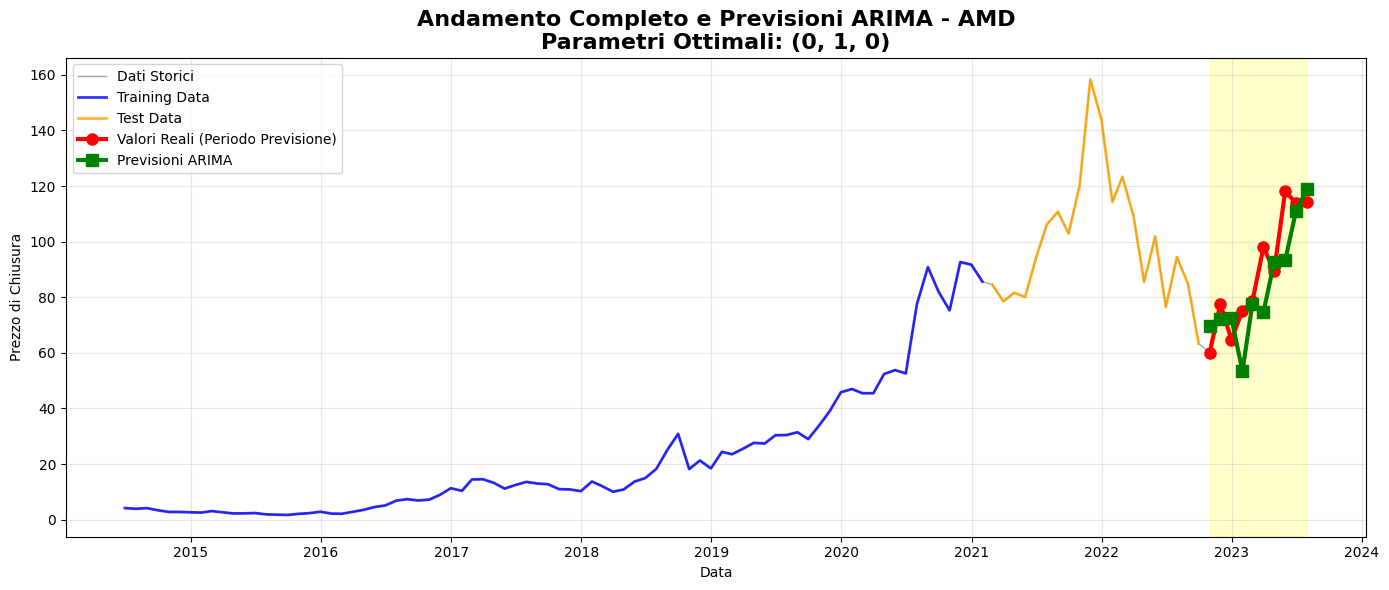

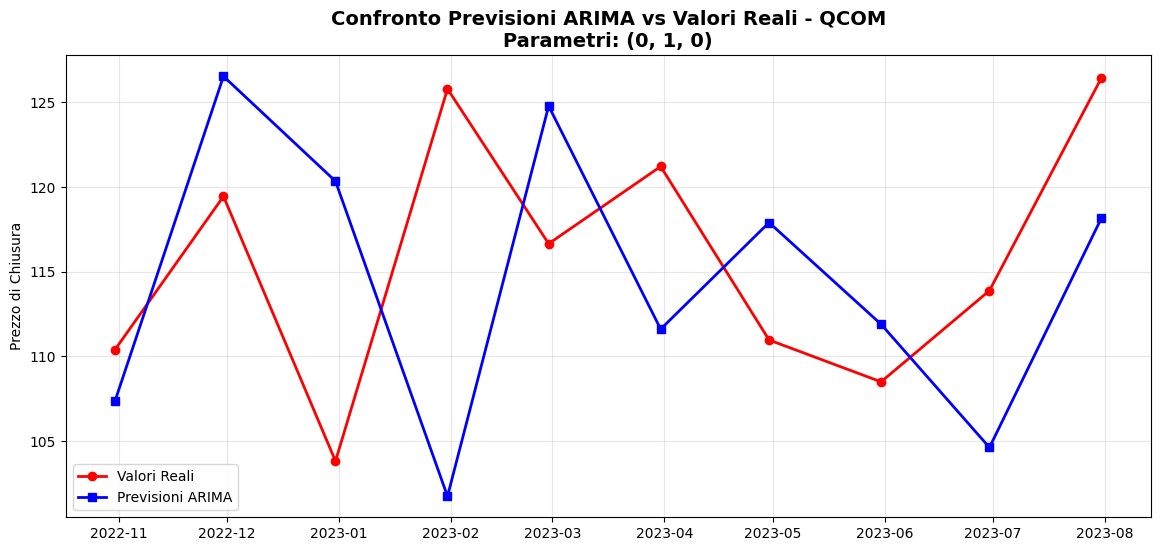

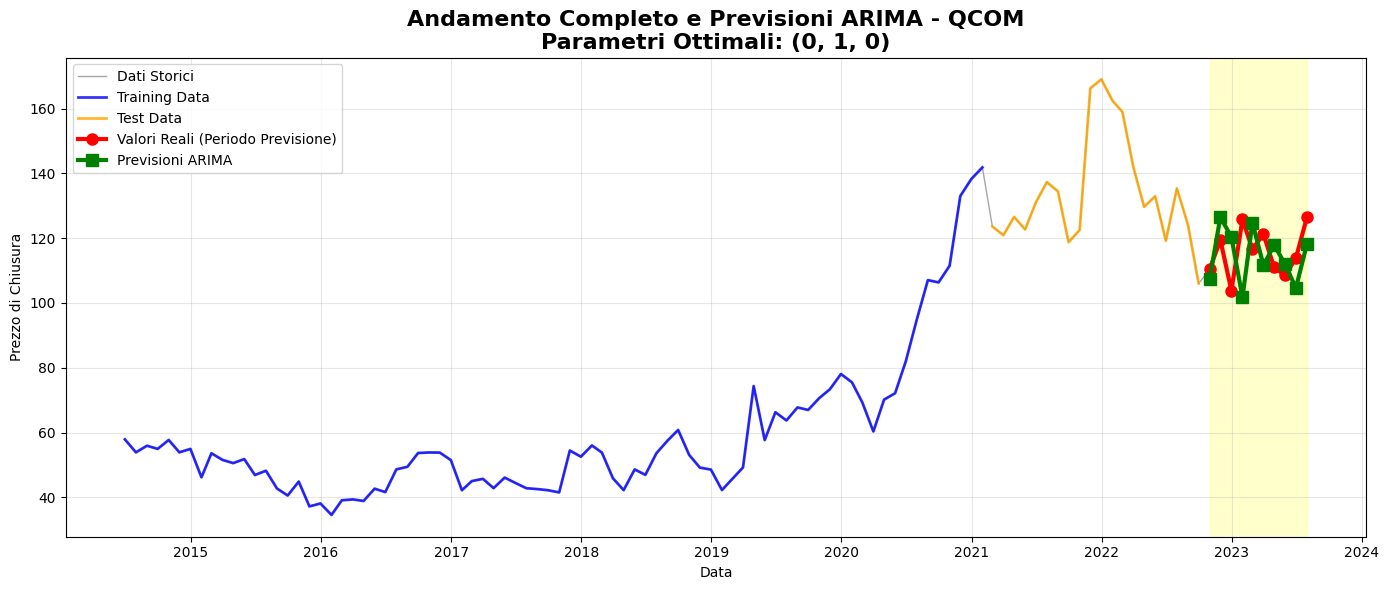

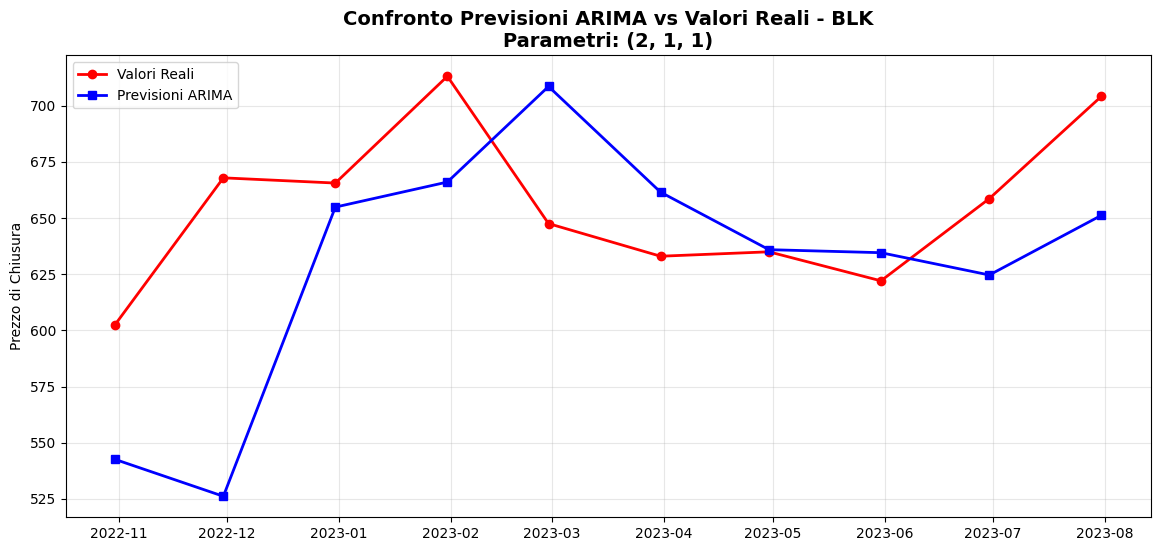

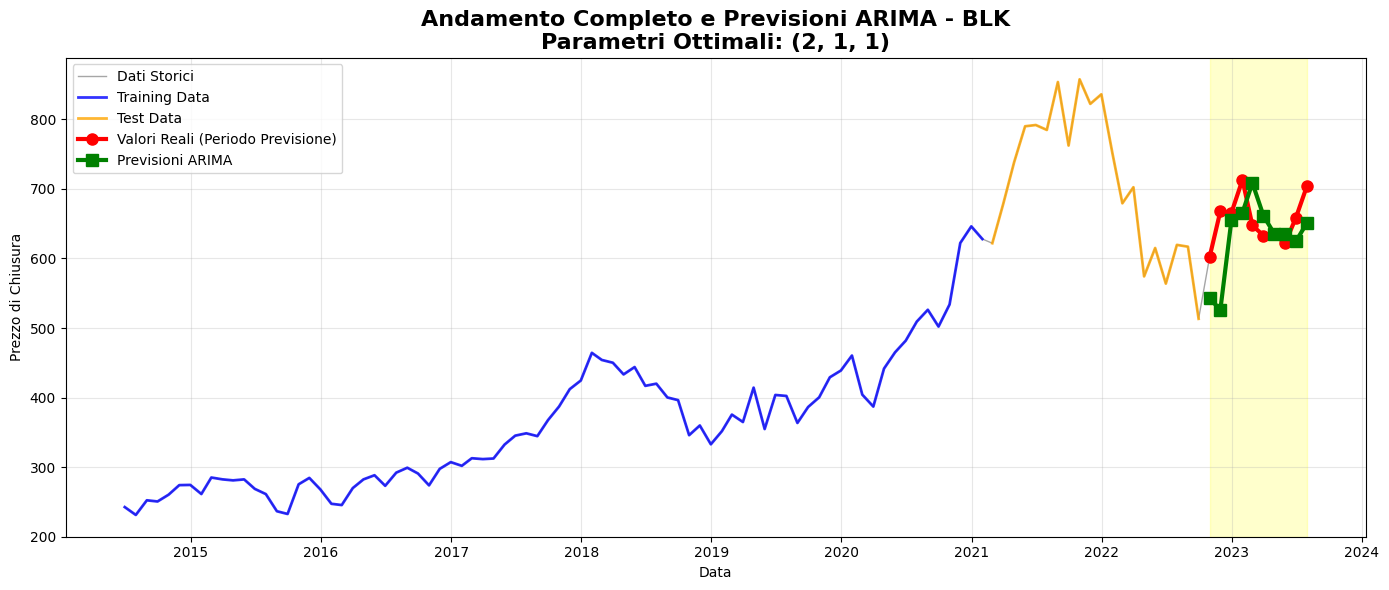

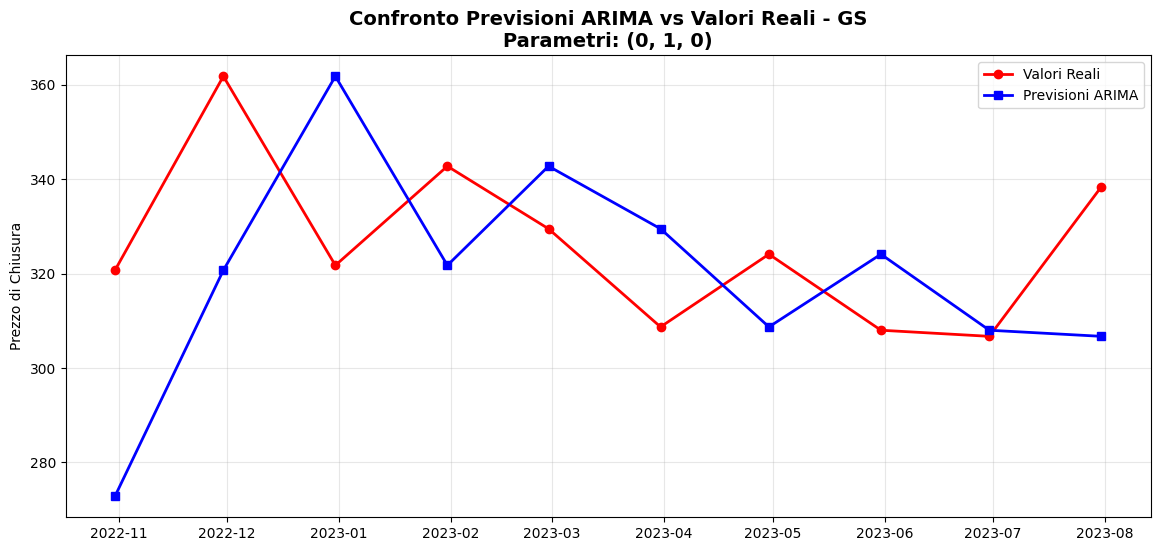

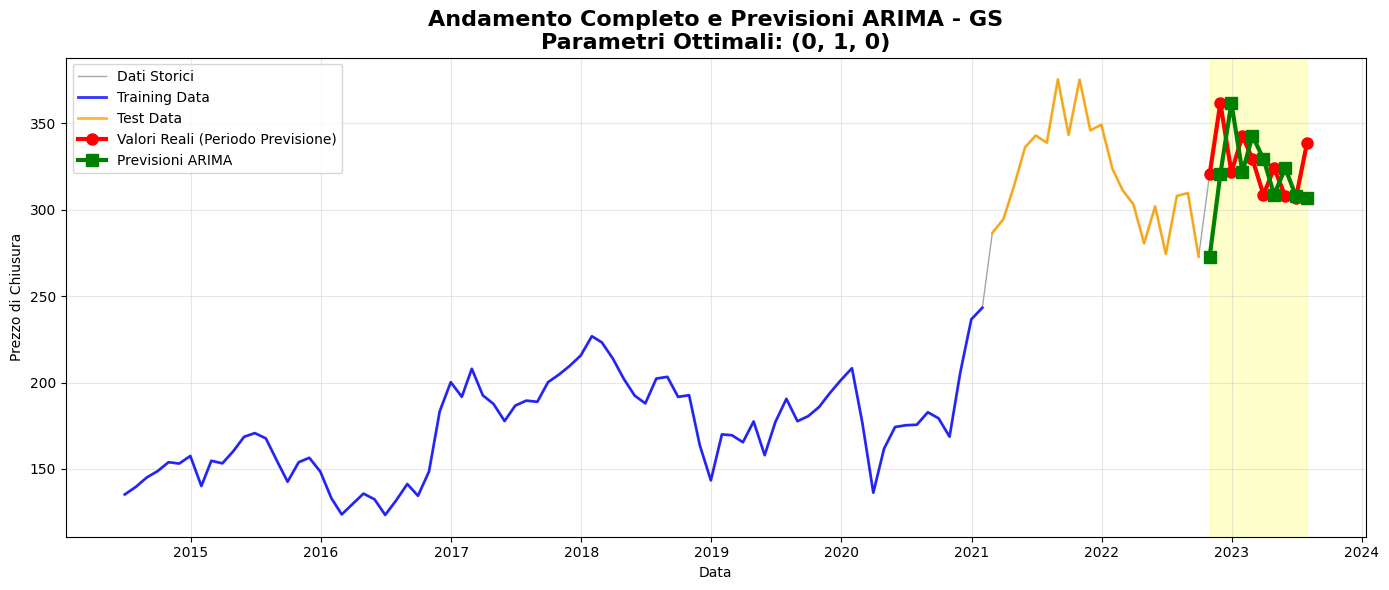

  Ticker     RMSE
0    NOC  38.8107
1     BA  18.7153
2    AMD  13.6279
3   QCOM  11.3272
4    BLK  58.8479
5     GS  28.5404


In [19]:
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

# Resampling dei dati di chiusura su base mensile, prendendo l'ultimo valore di ogni mese
monthly_close = data['Close'].resample('ME').last()

# Definziione delle dimensioni dei set di dati
train_len = 80 # Lunghezza del set di training (80 mesi)
test_len = 30 # Lunghezza del set di test (30 mesi)
prev_len = 10 # Numero di previsioni da fare (10 mesi)

# Lista per memorizzare i risultati di tutti i ticker
results = []

# Ciclo principale su ogni ticker
for ticker in tickers:
    # Estrazione i prezzi del ticker corrente e rimuove i valori NaN
    ticker_prices = monthly_close[ticker].dropna()

    # Divisione dei dati in training e test set
    train_data = ticker_prices.iloc[:train_len]
    test_data = ticker_prices.iloc[train_len:train_len + test_len]

    # Inizializzazione delle liste per le previsioni e i valori reali
    predictions = []
    actuals = test_data[-prev_len:] # Ultimi 10 valori del test set
    history = list(train_data.values) + list(test_data[:-prev_len].values)

    # Variabili per tracciare il miglior modello
    best_order = None
    best_rmse = None

    # Ciclo per fare previsioni step-by-step
    for t in range(prev_len): 
        model = auto_arima(
            history,
            start_p=1, start_q=1,
            max_p=5, max_q=5, max_d=2,
            seasonal=True, m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore'
        )

        # Salvataggio dei parametri del primo modello per riferimento
        if best_order is None:
            best_order = model.order
            val_forecast = model.predict_in_sample()
            best_rmse = root_mean_squared_error(history, val_forecast)

        forecast = model.predict(n_periods=1)[0]
        predictions.append(forecast)

        history.append(actuals.iloc[t])

    # Calcolo RMSE finale
    rmse = root_mean_squared_error(actuals, predictions)

    results.append({
        'Ticker': ticker,
        'RMSE': rmse,
        'Valori Reali': actuals.values,
        'Previsioni': predictions,
        'Date': actuals.index
    })

    # Grafico comparativo migliorato
    plt.figure(figsize=(14, 6))

    plt.plot(actuals.index, actuals.values, marker='o', linewidth=2,
             label='Valori Reali', color='red', markersize=6)
    plt.plot(actuals.index, predictions, marker='s', linewidth=2,
             label='Previsioni ARIMA', color='blue', markersize=6)

    plt.title(f'Confronto Previsioni ARIMA vs Valori Reali - {ticker}\nParametri: {best_order}',
              fontsize=14, fontweight='bold')
    plt.ylabel('Prezzo di Chiusura')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Grafico aggiuntivo: andamento completo
    plt.figure(figsize=(14, 6))

    full_history = pd.concat([train_data, test_data])
    plt.plot(full_history.index, full_history.values, color='gray', alpha=0.7,
             linewidth=1, label='Dati Storici')
    plt.plot(train_data.index, train_data.values, color='blue', alpha=0.8,
             linewidth=2, label='Training Data')

    test_no_pred = test_data[:-prev_len]
    plt.plot(test_no_pred.index, test_no_pred.values, color='orange', alpha=0.8,
             linewidth=2, label='Test Data')

    plt.plot(actuals.index, actuals.values, marker='o', color='red',
             linewidth=3, markersize=8, label='Valori Reali (Periodo Previsione)')

    plt.plot(actuals.index, predictions, marker='s', color='green',
             linewidth=3, markersize=8, label='Previsioni ARIMA')

    plt.title(f'Andamento Completo e Previsioni ARIMA - {ticker}\nParametri Ottimali: {best_order}',
              fontsize=16, fontweight='bold')
    plt.ylabel('Prezzo di Chiusura')
    plt.xlabel('Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.axvspan(actuals.index[0], actuals.index[-1], alpha=0.2, color='yellow',
                label='Periodo Previsione')

    plt.tight_layout()
    plt.show()

# Tabella finale RMSE
results_df = pd.DataFrame(results)
print(results_df[['Ticker', 'RMSE']].round(4))


# Analisi tecnica - Relative Strength Index (RSI)


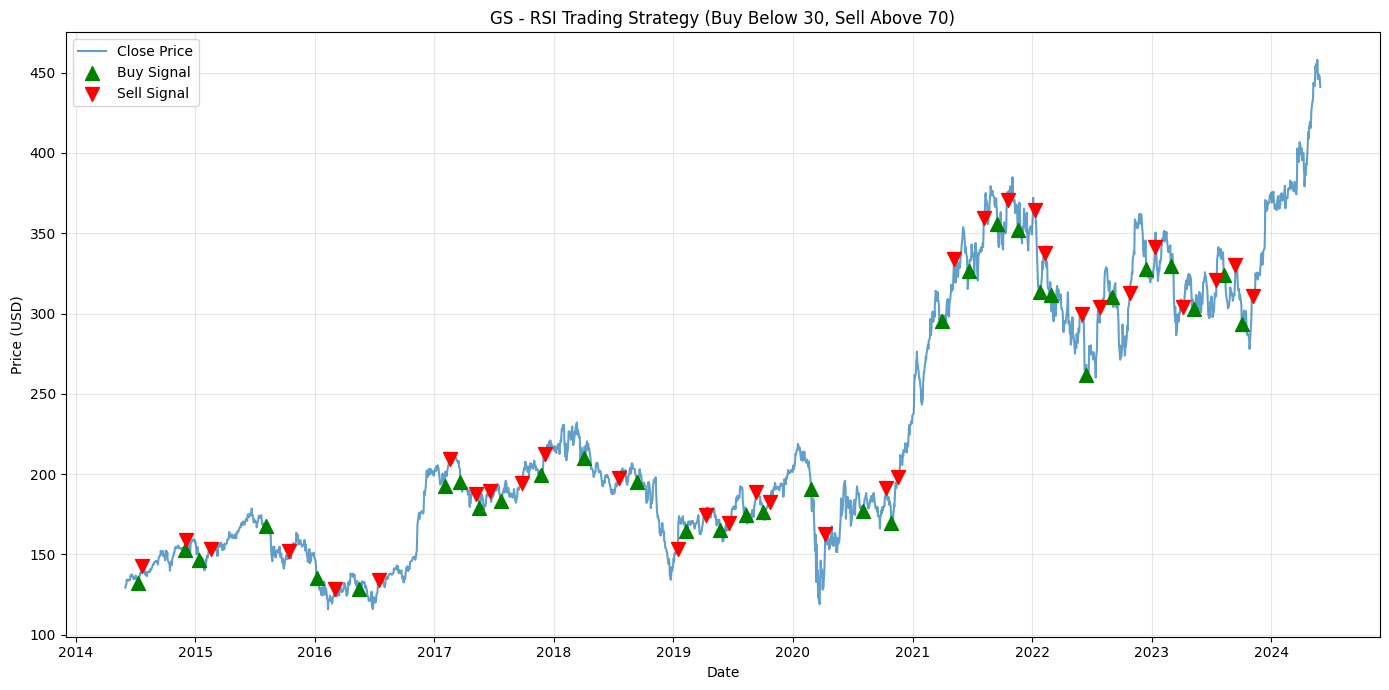

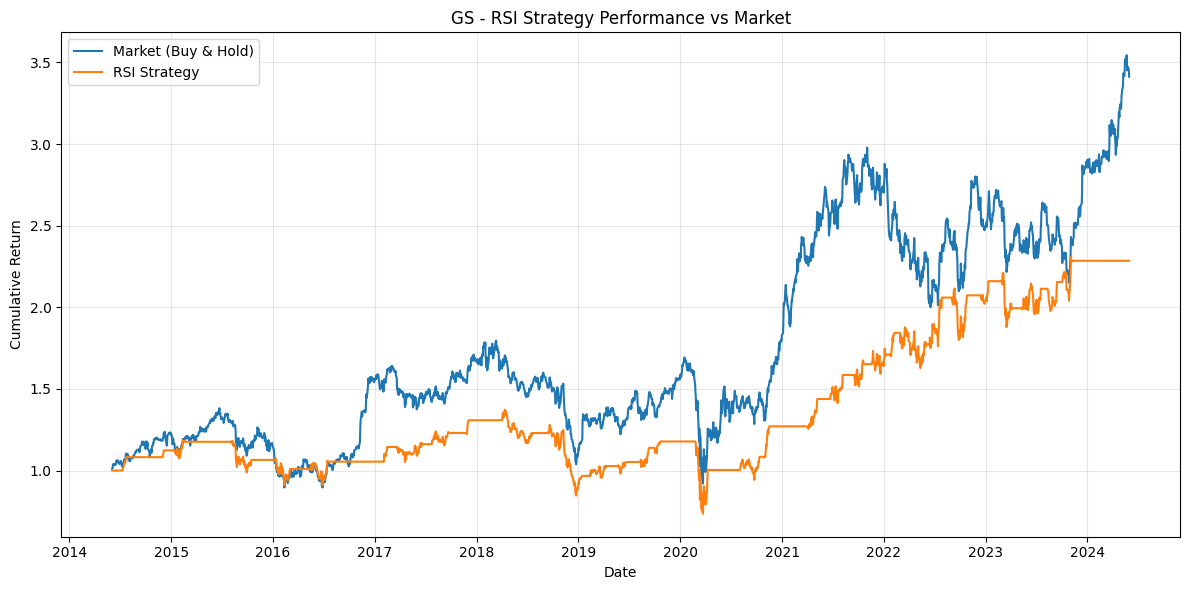

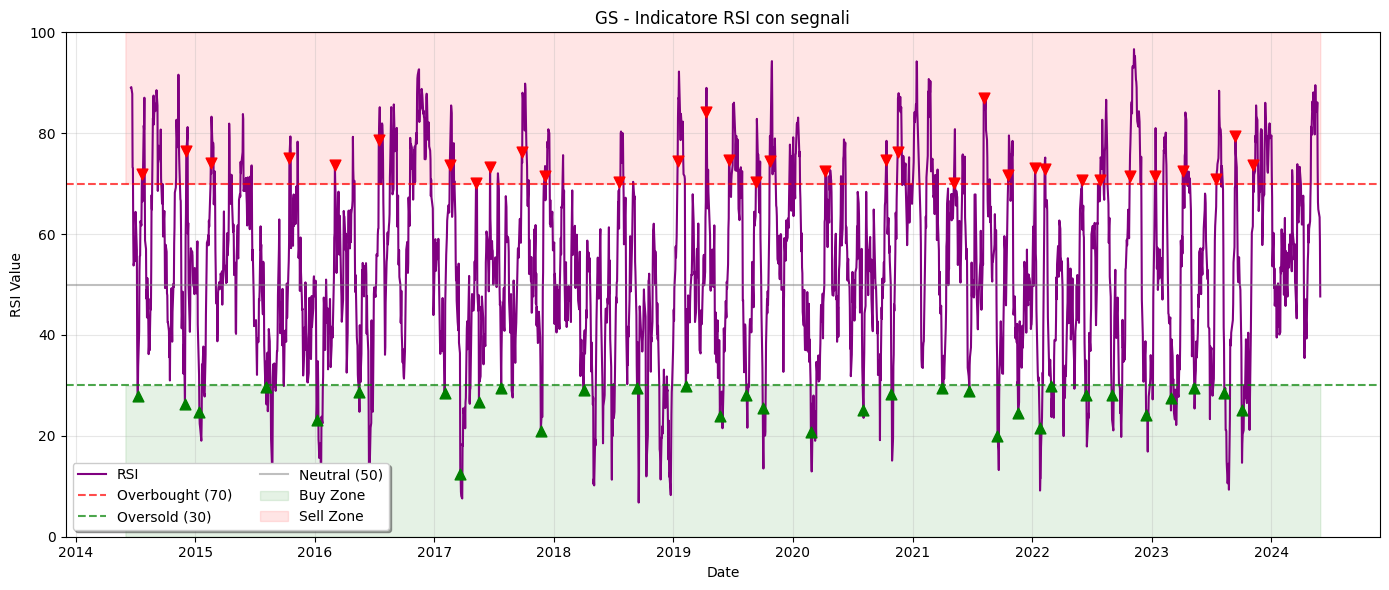

Analisi delle performance per il titolo - GS

Mercato (Buy & Hold):
Total Return: 241.22%
Annual Return: 17.67%
Volatility: 28.22%
Sharpe Ratio: 0.63
Max Drawdown: -48.75%

Strategia RSI:
Total Return: 128.49%
Annual Return: 11.08%
Volatility: 21.13%
Sharpe Ratio: 0.52
Max Drawdown: -46.45%


In [20]:
# Definzione del titolo su cui fare l'analisi
TICKER = 'GS'

# Estrazione dei dati del ticker selezionato
ticker_data = data.xs(TICKER, axis=1, level='Ticker', drop_level=True).copy()

# Funzione per il calcolo dell'RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calcolo RSI
ticker_data['RSI'] = calculate_rsi(ticker_data['Close'])   

# Inizializzazione segnali e posizioni
ticker_data['Signal'] = 0
ticker_data['Position'] = 0

# Logica long-only: compra sotto 30, vendi sopra 70
current_position = 0
positions = []

for i in range(len(ticker_data)):
    if ticker_data['RSI'].iloc[i] < 30 and current_position == 0:
        # Segnale di acquisto (entra in posizione long)
        ticker_data.loc[ticker_data.index[i], 'Signal'] = 1
        current_position = 1
    elif ticker_data['RSI'].iloc[i] > 70 and current_position == 1:
        # Segnale di vendita (esce dalla posizione long)
        ticker_data.loc[ticker_data.index[i], 'Signal'] = -1
        current_position = 0
    
    positions.append(current_position)

# Assegna le posizioni con shift per evitare look-ahead bias
ticker_data['Position'] = [0] + positions[:-1]  # Shift di 1 periodo

# Calcolo dei rendimenti
ticker_data['Market Return'] = ticker_data['Close'].pct_change()
ticker_data['Strategy Return'] = ticker_data['Market Return'] * ticker_data['Position']

# Grafico di visualizzazione dei segnali
plt.figure(figsize=(14, 7))
plt.plot(ticker_data['Close'], label='Close Price', alpha=0.7)

# Segnali di acquisto (entrata posizione long)
buy_signals = ticker_data[ticker_data['Signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['Close'],
           label='Buy Signal', marker='^', color='green', s=100, zorder=5)

# Segnali di vendita (uscita posizione long)
sell_signals = ticker_data[ticker_data['Signal'] == -1]
plt.scatter(sell_signals.index, sell_signals['Close'],
           label='Sell Signal', marker='v', color='red', s=100, zorder=5)

plt.title(f'{TICKER} - RSI Trading Strategy (Buy Below 30, Sell Above 70)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graifco performance cumulative
cumulative_returns = (1 + ticker_data[['Market Return', 'Strategy Return']]).cumprod()

plt.figure(figsize=(12, 6)) 
plt.plot(cumulative_returns.index, cumulative_returns['Market Return'], label='Market (Buy & Hold)')
plt.plot(cumulative_returns.index, cumulative_returns['Strategy Return'], label='RSI Strategy')
plt.title(f'{TICKER} - RSI Strategy Performance vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Grafico RSI con livelli di soglia
plt.figure(figsize=(14, 6))
plt.plot(ticker_data['RSI'], label='RSI', color='purple', linewidth=1.5)
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.5, label='Neutral (50)')

# Evidenzia i punti di segnale sull'RSI
plt.scatter(buy_signals.index, buy_signals['RSI'],
           color='green', marker='^', s=60, zorder=5)
plt.scatter(sell_signals.index, sell_signals['RSI'],
           color='red', marker='v', s=60, zorder=5)

plt.fill_between(ticker_data.index, 30, 0, alpha=0.1, color='green', label='Buy Zone')
plt.fill_between(ticker_data.index, 70, 100, alpha=0.1, color='red', label='Sell Zone')

plt.title(f'{TICKER} - Indicatore RSI con segnali')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.ylim(0, 100)
plt.legend(
    loc='best',           
    frameon=True,         
    fancybox=True,        
    shadow=True,         
    ncol=2,               
    fontsize=10           
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiche della strategia
def calculate_strategy_stats(returns):
    returns_clean = returns.dropna()
    if len(returns_clean) == 0:
        return {
            'Total Return': "0.00%",
            'Annual Return': "0.00%",
            'Volatility': "0.00%",
            'Sharpe Ratio': "0.00",
            'Max Drawdown': "0.00%"
        }
    
    total_return = (1 + returns_clean).prod() - 1
    annual_return = (1 + returns_clean.mean()) ** 252 - 1 
    volatility = returns_clean.std() * (252 ** 0.5)
    sharpe_ratio = annual_return / volatility if volatility != 0 else 0
    
    # Calcolo del Max Drawdown
    cumulative = (1 + returns_clean).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Total Return': f"{total_return:.2%}",
        'Annual Return': f"{annual_return:.2%}",
        'Volatility': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    }

# Calcola statistiche per entrambe le strategie
market_stats = calculate_strategy_stats(ticker_data['Market Return'])
strategy_stats = calculate_strategy_stats(ticker_data['Strategy Return'])

print(f"Analisi delle performance per il titolo - {TICKER}")

print(f"\nMercato (Buy & Hold):")
for key, value in market_stats.items():
    print(f"{key}: {value}")

print(f"\nStrategia RSI:")
for key, value in strategy_stats.items():
    print(f"{key}: {value}")

# CAMP (Capital Asset Pricing Model)

# Calcolare il beta di ciascun titolo o ETF rispetto al mercato indice S&P 500

In [21]:
start = pd.Timestamp('2014-05-31')
end = pd.Timestamp('2024-05-31')

# Downlaod dei dati mensili dell'indice S&P 500
sp500_data = yf.download('^GSPC', start=start, end=end, progress=False)['Close']
sp500_data = sp500_data.resample('ME').last()
market_returns = sp500_data.pct_change().dropna()
market_returns.columns = ['Mkt_Ret']

# Allinea le date con i ritorni dei titoli
monthly_returns = monthly_log_returns.loc[market_returns.index]

monthly_returns.head()

# 3. Download dell'asset Fama-French risk-free
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_monthly.rename({'date_ff_factors': 'Date'}, axis=1, inplace=True)
ff3_monthly['Date'] = pd.to_datetime(ff3_monthly['Date'])
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly = ff3_monthly.resample('ME').last()

# Divisione per 100 dei dati Fama-French che sono espressi in percentuale
ff3_monthly['RF'] = ff3_monthly['RF'] / 100.0

# Combinazione dei dati e calcolo degli excess returns
combined_data = monthly_returns.merge(market_returns, on='Date', how='inner')
combined_data = combined_data.merge(ff3_monthly[['RF']], on='Date', how='inner')

# Calcolo degli excess return per il mercato
combined_data['Mkt-RF'] = combined_data['Mkt_Ret'] - combined_data['RF']

betas = {}
alphas = {}

# Esecuzione della regression per ogni titolo
for ticker in monthly_returns.columns:
    # Calolo degli excess return per la stock
    combined_data[f'{ticker}-RF'] = combined_data[ticker] - combined_data['RF']

    # Definizione della variabile dipendente (y) e indipendente (x)
    y = combined_data[f'{ticker}-RF']
    X = combined_data['Mkt-RF']
    X1 = sm.add_constant(X) # Add an intercept (alpha) to the model

    # Fit del modello OLS
    model = sm.OLS(y, X1, missing='drop')
    results = model.fit()

    # Intercette alpha e beta
    alpha, beta = results.params
    alphas[ticker] = alpha
    betas[ticker] = beta

# Salvataggio in un dataframe
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Beta': betas
})

display(results_df)

,Alpha,Beta
NOC,0.008112,0.467742
BA,-0.010241,1.516029
AMD,0.011614,2.089585
QCOM,-0.002289,1.373972
BLK,-0.003406,1.380892
GS,-0.002641,1.358031


# Calcolo del rendimento annuo del titolo utilizzando il beta e una previsione del rendimento dell'S&P500 e del T-Bill a 1 anno

In [22]:
# Stima dei parametri di mercato
RISK_FREE_RATE = 0.045      # T-Bill 1 anno (4.5% stimato)
MARKET_RETURN_ESTIMATE = 0.08  # Rendimento atteso S&P 500 (8% stimato)
MARKET_PREMIUM = MARKET_RETURN_ESTIMATE - RISK_FREE_RATE

expected_returns = {}
for ticker, beta in betas.items():
    expected_return = RISK_FREE_RATE + beta * MARKET_PREMIUM
    expected_returns[ticker] = expected_return

# Crea DataFrame con i rendimenti attesi
expected_returns_df = pd.DataFrame.from_dict(expected_returns, orient='index', columns=['Expected_Return'])
expected_returns_df.index.name = 'Ticker'

expected_returns_df = pd.DataFrame.from_dict(expected_returns, orient='index', columns=['Expected_Return'])
expected_returns_df.index.name = 'Ticker'
expected_returns_df['Expected_Return_%'] = (expected_returns_df['Expected_Return'] * 100).round(2)

# Stampa dei risultati
print("Rendimenti attesi (CAPM) per ciascun titolo:")
for ticker, row in expected_returns_df.iterrows():
    print(f"{ticker}: {row['Expected_Return_%']}%")

Rendimenti attesi (CAPM) per ciascun titolo:
NOC: 6.14%
BA: 9.81%
AMD: 11.81%
QCOM: 9.31%
BLK: 9.33%
GS: 9.25%


# Calcolo l’esposizione di  ciascun titolo o ETF ai fattori di rischio Fama-French

In [23]:
# I fattori SMB e HML sono già disponibili nel dataset ff3_monthly
ff3_factors = ff3_monthly[['RF', 'Mkt-RF', 'SMB', 'HML']].copy()

# Combina tutti i dati necessari per l'analisi Fama-French
ff_combined_data = monthly_returns.merge(ff3_factors, on='Date', how='inner')

# Dizionari per memorizzare i risultati del modello Fama-French
ff_alphas = {}
ff_betas_market = {}
ff_betas_smb = {}
ff_betas_hml = {}
ff_r_squared = {}
ff_results_summary = {}

# Esecuzione della regressione Fama-French per ogni titolo
for ticker in monthly_returns.columns:
    
    # Calcolo i rendimenti in eccesso per il titolo
    ff_combined_data[f'{ticker}-RF'] = ff_combined_data[ticker] - ff_combined_data['RF']
    
    # Definizione delle variabili dipendenti e indipendenti
    y = ff_combined_data[f'{ticker}-RF']
    X = ff_combined_data[['Mkt-RF', 'SMB', 'HML']]
    
    # Aggiunta della costante per l'alpha
    X_with_const = sm.add_constant(X)
    
    # Esecuzione della regressione OLS
    model = sm.OLS(y, X_with_const, missing='drop')
    results = model.fit()
    
    # Estrazione dei coefficienti
    alpha = results.params['const']
    beta_market = results.params['Mkt-RF']
    beta_smb = results.params['SMB'] 
    beta_hml = results.params['HML']
    
    # Memorizzazione dei risultati
    ff_alphas[ticker] = alpha
    ff_betas_market[ticker] = beta_market
    ff_betas_smb[ticker] = beta_smb
    ff_betas_hml[ticker] = beta_hml
    ff_r_squared[ticker] = results.rsquared
    ff_results_summary[ticker] = results

# Creazione DataFrame con tutti i risultati Fama-French
ff_results_df = pd.DataFrame({
    'const': ff_alphas,
    'Mkt-RF': ff_betas_market,
    'SMB': ff_betas_smb,
    'HML': ff_betas_hml,
    'R_Squared': ff_r_squared
})

# Print dei risultati
print("\nRisultati Fama-French Three-Factor Model")
print(ff_results_df.round(4))


Risultati Fama-French Three-Factor Model
       const  Mkt-RF     SMB     HML  R_Squared
NOC   0.0073  0.5147 -0.4467  0.2378     0.1715
BA   -0.0082  1.4182  0.3365  0.5229     0.3890
AMD   0.0100  2.0406  0.0509 -0.7870     0.3742
QCOM -0.0031  1.3583 -0.1806 -0.1562     0.3366
BLK  -0.0031  1.3378 -0.0316  0.1485     0.7067
GS   -0.0009  1.2970  0.1343  0.6965     0.6904


# Strategie di trading e backtesting – Strategie dinamiche  

[*********************100%***********************]  6 of 6 completed


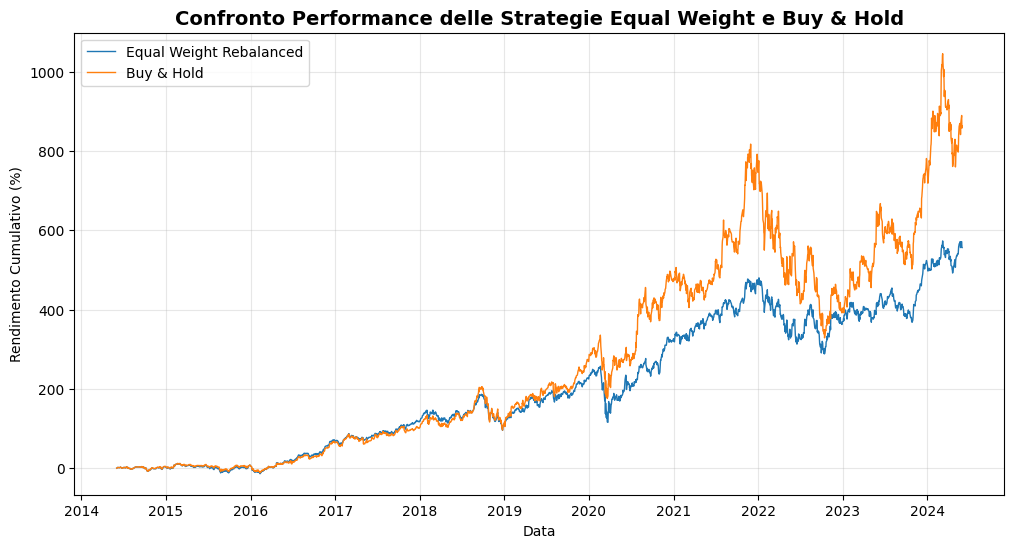

Statistche della strategia Equally Weight


c:\Users\lucag\Desktop\Progetto-BISF\progetto_bisf\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.738%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2014-06-03
End date,2024-05-30
Total months,119
,Backtest
Annual return,20.738%
Cumulative returns,556.331%
Annual volatility,24.869%
Sharpe ratio,0.88
Calmar ratio,0.52
Stability,0.95
Max drawdown,-39.564%


Statistche della strategia Buy & Hold


c:\Users\lucag\Desktop\Progetto-BISF\progetto_bisf\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.472%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2014-06-03
End date,2024-05-30
Total months,119
,Backtest
Annual return,25.472%
Cumulative returns,863.606%
Annual volatility,31.993%
Sharpe ratio,0.87
Calmar ratio,0.48
Stability,0.95
Max drawdown,-53.25%


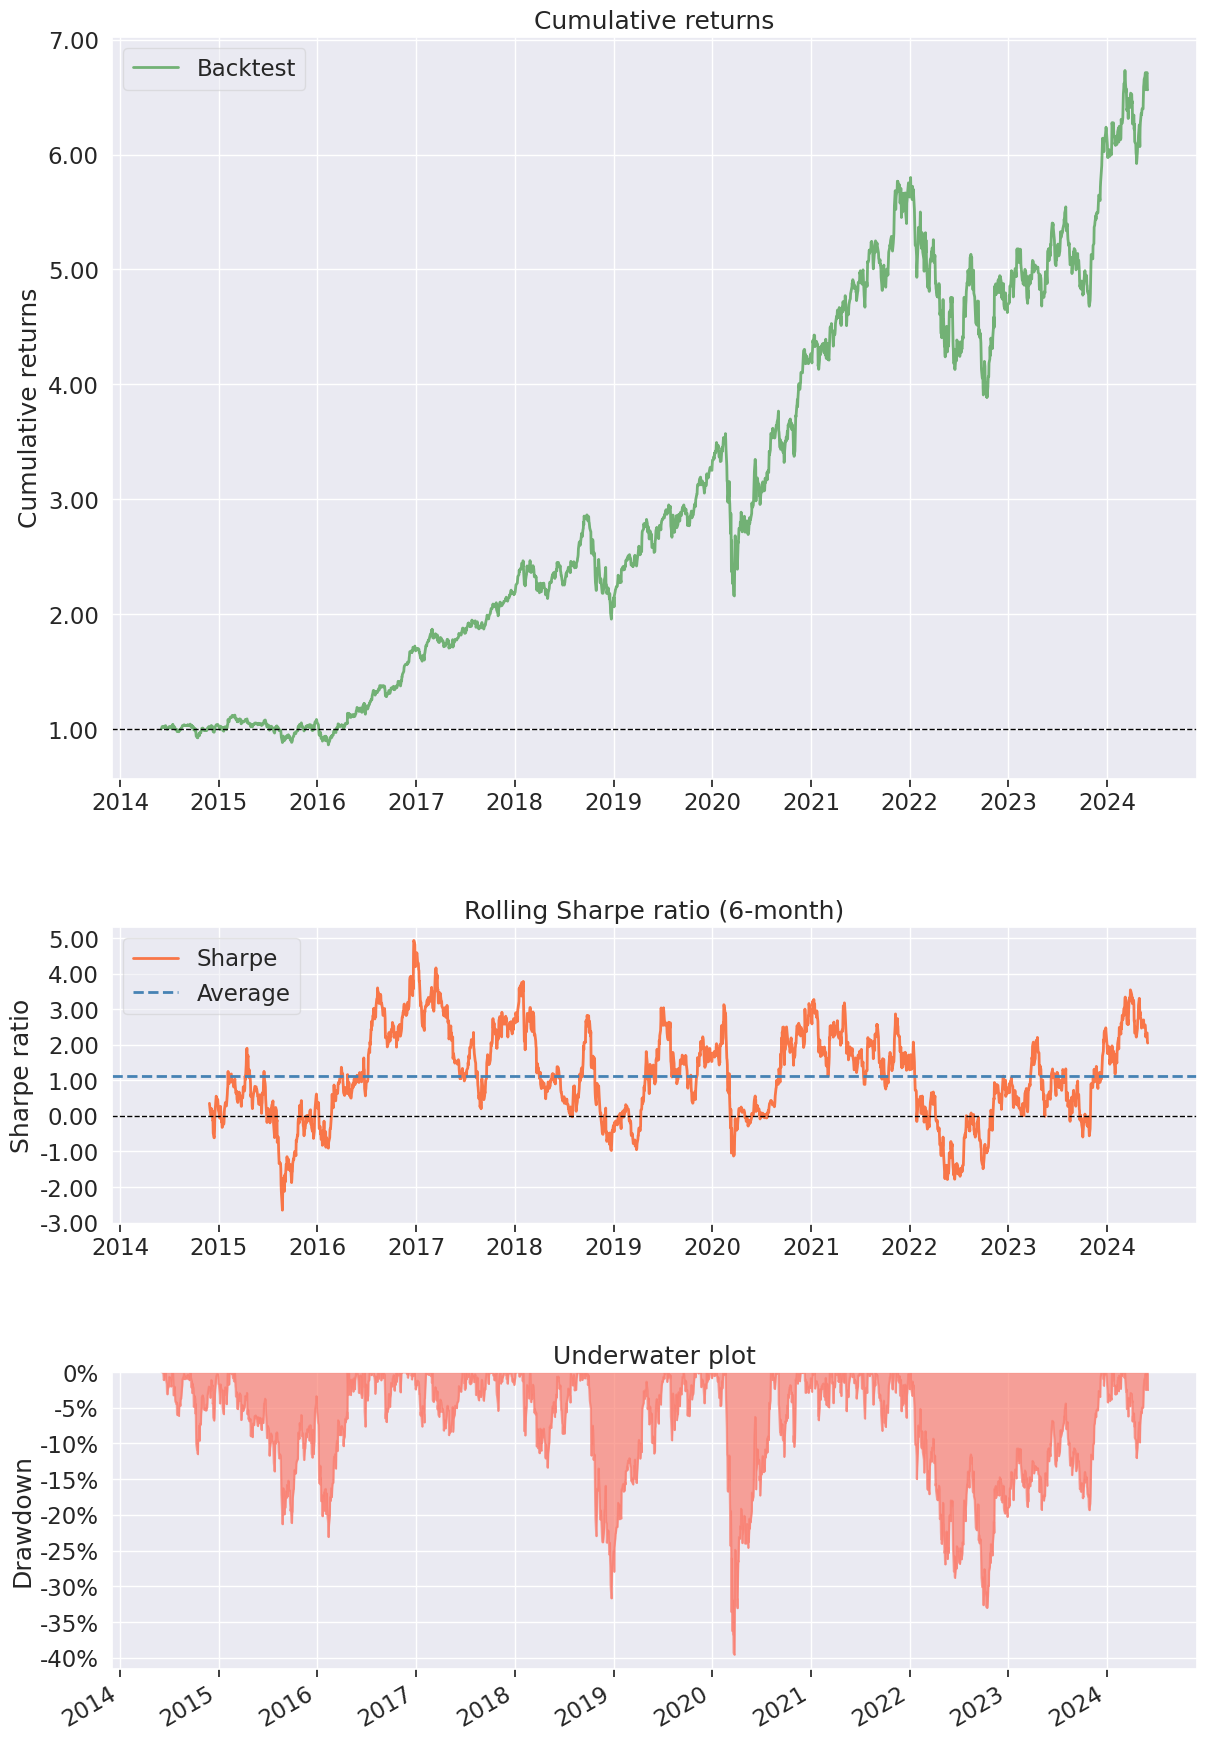

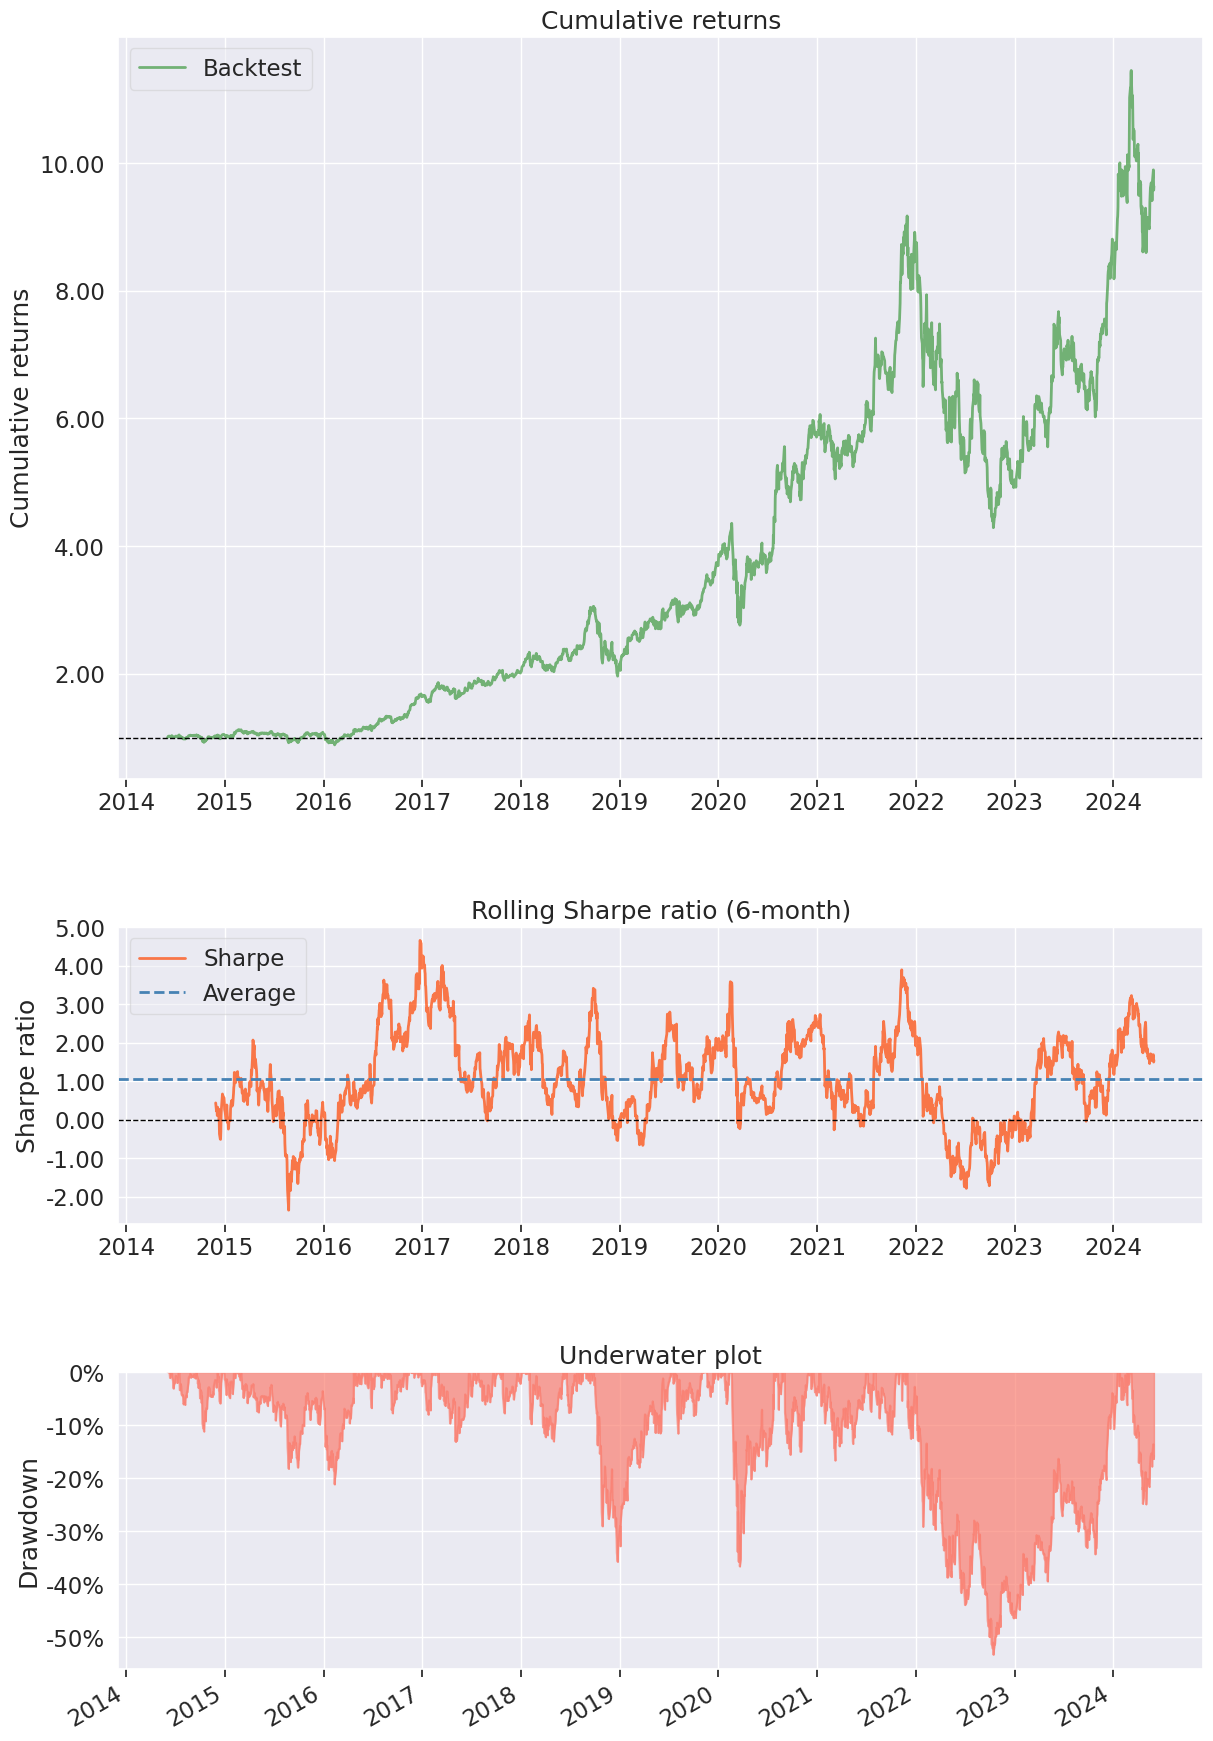

In [24]:
# Frequenza di ribilanciamento
rebalance_freq = 'QE'

# Download dei dati
start = pd.Timestamp('2014-05-31')
end = pd.Timestamp('2024-05-31')

tickers = ['NOC', 'BA', 'AMD', 'QCOM', 'BLK', 'GS']
data = yf.download(tickers=tickers, start=start, end=end)

# Selezione dei dati di chiusura per ciascun ticker
closes = data['Close']

# Calcolo rendimenti
returns = closes.pct_change().dropna()
rebalance_dates = returns.resample(rebalance_freq).first().index

# Calcolo del portafoglio
def equal_weight_portfolio(prices, rebalance_dates):
    n_assets = prices.shape[1]
    weights = np.repeat(1 / n_assets, n_assets)
    portfolio = pd.Series(index=prices.index, dtype=float)

    # Inizio con valore 1 (normalizzato)
    capital = 1.0
    shares = None

    for date in prices.index:
        if shares is None or date in rebalance_dates:
            # Se è una data di ribilanciamento, vendi tutto e ricompri
            if shares is not None:
                # Vendi tutto: calcola capitale attuale
                capital = (shares * prices.loc[date]).sum()
            # Ricompra tutto equal weight
            shares = (capital * weights) / prices.loc[date]

        # Calcola valore attuale del portafoglio
        portfolio[date] = (shares * prices.loc[date]).sum()

    return portfolio

def buy_and_hold_portfolio(prices):
    weights = np.repeat(1 / prices.shape[1], prices.shape[1])
    start_date = prices.index[0]
    # Capitale 1 (normalizzato)
    holdings = weights / prices.loc[start_date]
    return (prices * holdings).sum(axis=1)

# Calcolo valori giornalieri (normalizzati)
portfolio_eq = equal_weight_portfolio(closes, rebalance_dates)
portfolio_bh = buy_and_hold_portfolio(closes)

# Normalizzazione a base 1 per confronto
portfolio_eq = portfolio_eq / portfolio_eq.iloc[0]
portfolio_bh = portfolio_bh / portfolio_bh.iloc[0]

# Calcolo dei rendimenti giornalieri per pyfolio
portfolio_returns_rebalanced = portfolio_eq.pct_change().dropna()
portfolio_returns_static = portfolio_bh.pct_change().dropna()

# Creazione del grafico di comparazione
plt.figure(figsize=(12, 6))

cum_returns_eq = (portfolio_eq - 1) * 100
cum_returns_bh = (portfolio_bh - 1) * 100

# Plot dei dati
plt.plot(portfolio_eq.index, cum_returns_eq.values, label='Equal Weight Rebalanced', linewidth=1)
plt.plot(portfolio_bh.index, cum_returns_bh.values, label='Buy & Hold', linewidth=1)
plt.title('Confronto Performance delle Strategie Equal Weight e Buy & Hold', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulativo (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Stampa statisctiche
print("Statistche della strategia Equally Weight")
pf.create_simple_tear_sheet(portfolio_returns_rebalanced)
print("Statistche della strategia Buy & Hold")
pf.create_simple_tear_sheet(portfolio_returns_static)